In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from scipy.stats import f_oneway
from scipy.stats import linregress

## Read Datasets

In [3]:
circuits = pd.read_csv('/content/drive/MyDrive/DPL_dataset/circuits.csv')
constructor_results = pd.read_csv('/content/drive/MyDrive/DPL_dataset/constructor_results.csv')
constructor_standings = pd.read_csv('/content/drive/MyDrive/DPL_dataset/constructor_standings.csv')
constructors = pd.read_csv('/content/drive/MyDrive/DPL_dataset/constructors.csv')
driver_standings = pd.read_csv('/content/drive/MyDrive/DPL_dataset/driver_standings.csv')
drivers = pd.read_csv('/content/drive/MyDrive/DPL_dataset/drivers.csv')
lap_times = pd.read_csv('/content/drive/MyDrive/DPL_dataset/lap_times.csv')
pit_stops = pd.read_csv('/content/drive/MyDrive/DPL_dataset/pit_stops.csv')
qualifying = pd.read_csv('/content/drive/MyDrive/DPL_dataset/qualifying.csv')
races = pd.read_csv('/content/drive/MyDrive/DPL_dataset/races.csv')
results = pd.read_csv('/content/drive/MyDrive/DPL_dataset/results.csv')
seasons = pd.read_csv('/content/drive/MyDrive/DPL_dataset/seasons.csv')
sprint_results = pd.read_csv('/content/drive/MyDrive/DPL_dataset/sprint_results.csv')
status = pd.read_csv('/content/drive/MyDrive/DPL_dataset/status.csv')

## Data Preprocessing

In [4]:
dfs = [circuits, constructor_results, constructor_standings, constructors, driver_standings, drivers, lap_times,
       pit_stops, qualifying, races, results, seasons, sprint_results, status]

In [ ]:
structure_info = {}

df_names = ["circuits", "constructor_results", "constructor_standings", "constructors",
            "driver_standings", "drivers", "lap_times", "pit_stops", "qualifying",
            "races", "results", "seasons", "sprint_results", "status"]


for name, df in zip(df_names, dfs):

        structure_info[name] = {
            'shape': df.shape,
            'dtypes': df.dtypes.value_counts().to_dict(),
            'missing_values': df.isnull().sum().to_dict(),
            'unique_values': {col: df[col].nunique() for col in df.columns}
        }

for name, info in structure_info.items():
    print(f"\nDataFrame: {name}")
    print(f"Shape: {info['shape']}")
    print(f"Data Types: {info['dtypes']}")
    print(f"Missing Values: {info['missing_values']}")
    print(f"Unique Values: {info['unique_values']}")

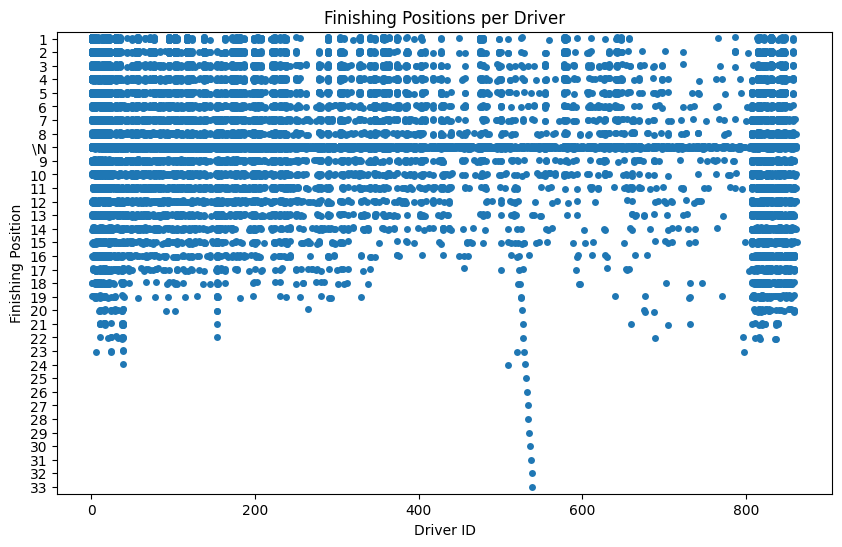

In [8]:
#Analysing Trends over years
#comparing finishing positions across drivers
plt.figure(figsize=(10, 6))
sns.stripplot(x='driverId', y='position', data=results, jitter=True)
plt.title('Finishing Positions per Driver')
plt.xlabel('Driver ID')
plt.ylabel('Finishing Position')
plt.show()

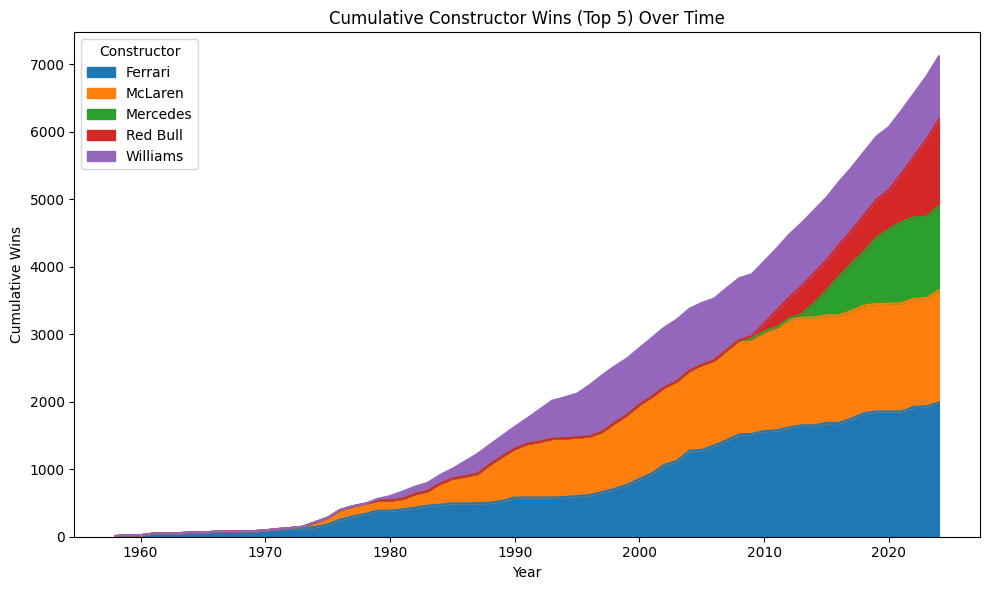

In [73]:
import pandas as pd
import matplotlib.pyplot as plt



# 2. Merge to include year (from races) and constructor name (from constructors)
df = pd.merge(constructor_standings, races[['raceId', 'year']], on='raceId')
df = pd.merge(df, constructors[['constructorId', 'name']], on='constructorId')

# 3. Group and aggregate total wins by constructor and year
wins_per_year = df.groupby(['year', 'name'])['wins'].sum().reset_index()

# 4. Identify top 5 constructors by overall (all-time) wins
total_wins = (
    wins_per_year.groupby('name')['wins']
    .sum()
    .reset_index()
    .sort_values('wins', ascending=False)
)
top_5_constructors = total_wins.head(5)['name'].tolist()

# 5. Filter the data to keep only these top 5 constructors
filtered_wins = wins_per_year[wins_per_year['name'].isin(top_5_constructors)]

# 6. Pivot so that each constructor’s wins per year become separate columns
pivoted = filtered_wins.pivot(index='year', columns='name', values='wins').fillna(0)

# Sort the year index to ensure a proper time series
pivoted = pivoted.sort_index()

# 7. Compute the cumulative wins over the seasons
cumulative_wins = pivoted.cumsum()

# 8. Plot an area chart
plt.figure(figsize=(10, 6))
cumulative_wins.plot.area(ax=plt.gca())  # Plot on the same axes
plt.title("Cumulative Constructor Wins (Top 5) Over Time")
plt.xlabel("Year")
plt.ylabel("Cumulative Wins")
plt.legend(title="Constructor", loc="upper left")
plt.tight_layout()
plt.show()
Use this as one trend

<ipython-input-76-32d3b9403cbb>:27: FutureWarning:



The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.



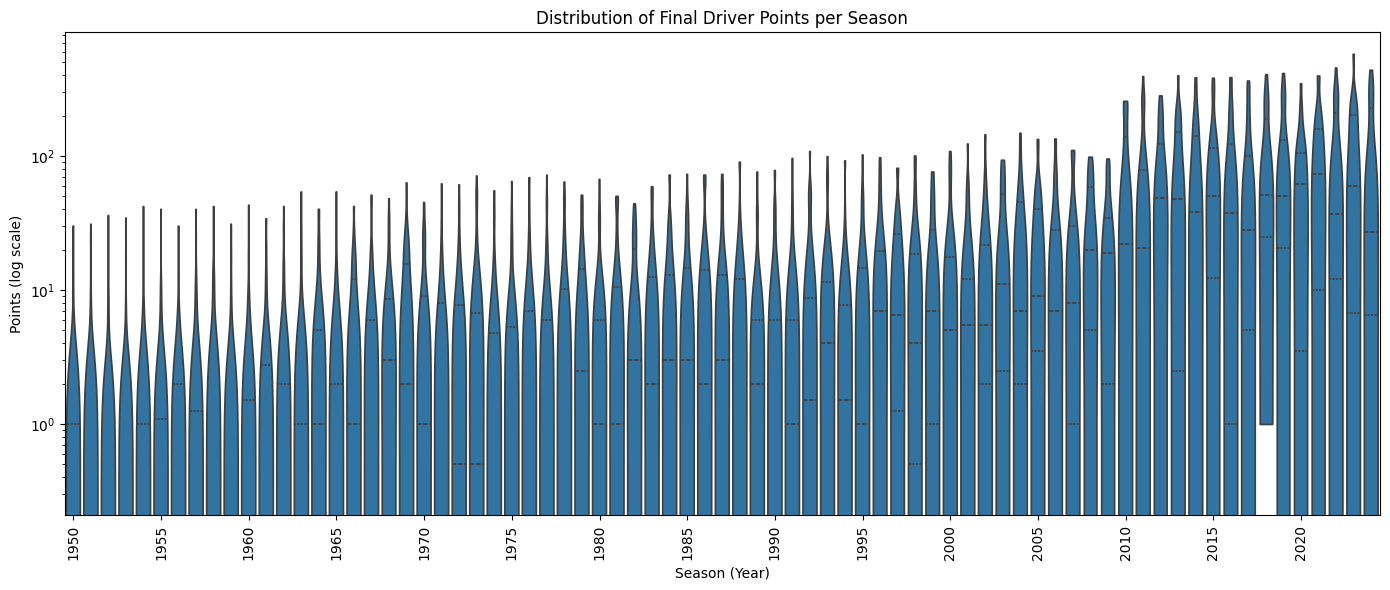

In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Merge while avoiding duplicate column conflicts
df_merged = pd.merge(
    driver_standings,
    races[['raceId', 'year']],
    on='raceId',
    suffixes=('', '_race')  # Rename duplicate 'year' column from races
)

# Ensure we're using the correct 'year' column
df_merged.rename(columns={'year': 'year_driver'}, inplace=True)

df_final = (
    df_merged
    .groupby(['year_driver', 'driverId'], as_index=False)['points']
    .max()  # Take the max points in that season for each driver
)

use_log_scale = True

plt.figure(figsize=(14, 6))

sns.violinplot(
    x='year_driver',  # Use renamed column
    y='points',
    data=df_final,
    inner='quartile',
    cut=0,            # Prevents violins from extending beyond the data range
    scale='width'     # Keeps violin widths comparable
)

plt.title('Distribution of Final Driver Points per Season')
plt.xlabel('Season (Year)')
plt.ylabel('Points Earned')

# Apply log scale to handle skew if desired
if use_log_scale:
    plt.yscale('log')
    plt.ylabel('Points (log scale)')

all_years = sorted(df_final['year_driver'].unique())
step = 5  # Label every 5th year (adjust as needed)
plt.xticks(
    ticks=np.arange(0, len(all_years), step),
    labels=[str(all_years[i]) for i in range(0, len(all_years), step)],
    rotation=90
)

plt.tight_layout()
plt.show()


In [11]:
# removing nan and duplicates from all data sets
for df in dfs:
    df.replace('\\N', np.nan, inplace=True)
    df.drop_duplicates(inplace=True)

In [12]:
#circuits
circuits['lat'] = pd.to_numeric(circuits['lat'], errors='coerce')
circuits['lng'] = pd.to_numeric(circuits['lng'], errors='coerce')
circuits['alt'] = pd.to_numeric(circuits['alt'], errors='coerce')
circuits['lat'] = circuits['lat'].fillna(circuits['lat'].median())
circuits['lng'] = circuits['lng'].fillna(circuits['lng'].median())
circuits['alt'] = circuits['alt'].fillna(circuits['alt'].median())

In [13]:
#Constructor results
constructor_results['constructorResultsId'] = pd.to_numeric(constructor_results['constructorResultsId'], errors='coerce')
constructor_results['points'] = pd.to_numeric(constructor_results['points'], errors='coerce')
points_median = constructor_results['points'].median()
constructor_results['points'].replace(r'\\N', points_median, inplace=True, regex=True)
constructor_results.replace("\\N", "Unknown", inplace=True)
print(constructor_results.head(5))

   constructorResultsId  raceId  constructorId  points status
0                     1      18              1    14.0    NaN
1                     2      18              2     8.0    NaN
2                     3      18              3     9.0    NaN
3                     4      18              4     5.0    NaN
4                     5      18              5     2.0    NaN


<ipython-input-13-19087da49120>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  constructor_results['points'].replace(r'\\N', points_median, inplace=True, regex=True)


In [14]:
#constructor_standings
constructor_standings['points'] = pd.to_numeric( constructor_standings['points'], errors='coerce')
points_median = constructor_standings['points'].median()
constructor_standings['points'].replace(r'\\N', points_median, inplace=True, regex=True)
print(constructor_standings.head(5))

   constructorStandingsId  raceId  constructorId  points  position  \
0                       1      18              1    14.0         1   
1                       2      18              2     8.0         3   
2                       3      18              3     9.0         2   
3                       4      18              4     5.0         4   
4                       5      18              5     2.0         5   

  positionText  wins  
0            1     1  
1            3     0  
2            2     0  
3            4     0  
4            5     0  


<ipython-input-14-ceebcec6c98c>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  constructor_standings['points'].replace(r'\\N', points_median, inplace=True, regex=True)


In [15]:
#constructors
constructors['nationality'].replace(r'\\N', "Unknown", inplace=True, regex=True)


<ipython-input-15-2b1118466760>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  constructors['nationality'].replace(r'\\N', "Unknown", inplace=True, regex=True)


In [16]:
#driver_standings
driver_standings['points'] = pd.to_numeric( driver_standings['points'], errors='coerce')
points_median = driver_standings['points'].median()
driver_standings.replace(r'\\N', points_median, inplace=True, regex=True)
driver_standings['positionText'].replace(r'\\N', "Unknown", inplace=True, regex=True)

<ipython-input-16-896237c8dcb3>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  driver_standings['positionText'].replace(r'\\N', "Unknown", inplace=True, regex=True)


In [17]:
#drivers
drivers['dob'] = pd.to_datetime(drivers['dob'], errors='coerce')

In [18]:
print(lap_times.head(5))

   raceId  driverId  lap  position      time  milliseconds
0     841        20    1         1  1:38.109         98109
1     841        20    2         1  1:33.006         93006
2     841        20    3         1  1:32.713         92713
3     841        20    4         1  1:32.803         92803
4     841        20    5         1  1:32.342         92342


In [19]:
#lap times
lap_times['milliseconds'] = pd.to_numeric(lap_times['milliseconds'], errors='coerce')
milliseconds_median = lap_times['milliseconds'].median()
lap_times['milliseconds'].fillna(milliseconds_median, inplace=True)

<ipython-input-19-8e55832db992>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  lap_times['milliseconds'].fillna(milliseconds_median, inplace=True)


In [20]:
print(pit_stops.head(5))

   raceId  driverId  stop  lap      time duration  milliseconds
0     841       153     1    1  17:05:23   26.898         26898
1     841        30     1    1  17:05:52   25.021         25021
2     841        17     1   11  17:20:48   23.426         23426
3     841         4     1   12  17:22:34   23.251         23251
4     841        13     1   13  17:24:10   23.842         23842


In [21]:
#pitstops
pit_stops['stop'] = pd.to_numeric(pit_stops['stop'], errors='coerce')
pit_stops['lap'] = pd.to_numeric(pit_stops['lap'], errors='coerce')
pit_stops['milliseconds'] = pd.to_numeric(pit_stops['milliseconds'], errors='coerce')
pit_stops['milliseconds'].fillna(pit_stops['milliseconds'].median(), inplace=True)
pit_stops['duration'] = pd.to_numeric(pit_stops['duration'], errors='coerce')
pit_stops['duration'].fillna(pit_stops['duration'].median(), inplace=True)


<ipython-input-21-8fc826977093>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pit_stops['duration'].fillna(pit_stops['duration'].median(), inplace=True)


In [22]:
#Qualifying
def time_to_ms(time_str):
    try:
        m, s = time_str.split(':')
        return int(m) * 60000 + float(s) * 1000  # Convert minutes & seconds
    except:
        return np.nan

# Convert the qualifying times to numeric format (milliseconds)
qualifying['q1'] = qualifying['q1'].apply(time_to_ms)
qualifying['q2'] = qualifying['q2'].apply(time_to_ms)
qualifying['q3'] = qualifying['q3'].apply(time_to_ms)

# Fill missing values with median
qualifying['q1'].fillna(qualifying['q1'].median(), inplace=True)
qualifying['q2'].fillna(qualifying['q2'].median(), inplace=True)
qualifying['q3'].fillna(qualifying['q3'].median(), inplace=True)

print(qualifying.head())

   qualifyId  raceId  driverId  constructorId  number  position       q1  \
0          1      18         1              1      22         1  86572.0   
1          2      18         9              2       4         2  86103.0   
2          3      18         5              1      23         3  85664.0   
3          4      18        13              6       2         4  85994.0   
4          5      18         2              2       3         5  85960.0   

        q2       q3  
0  85187.0  86714.0  
1  85315.0  86869.0  
2  85452.0  87079.0  
3  85691.0  87178.0  
4  85518.0  87236.0  


<ipython-input-22-1dad252a0a71>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  qualifying['q1'].fillna(qualifying['q1'].median(), inplace=True)
<ipython-input-22-1dad252a0a71>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

## Statistical Tests

Columns in merged_data: Index(['raceId', 'driverId', 'lap', 'position', 'time_lap', 'milliseconds',
       'year', 'round', 'circuitId', 'name', 'date', 'time_race', 'url',
       'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time',
       'quali_date', 'quali_time', 'sprint_date', 'sprint_time', 'circuitRef',
       'name_circuit', 'location', 'country', 'lat', 'lng', 'alt',
       'url_circuit'],
      dtype='object')
F-statistic: 317.4784285795587, P-value: 0.0


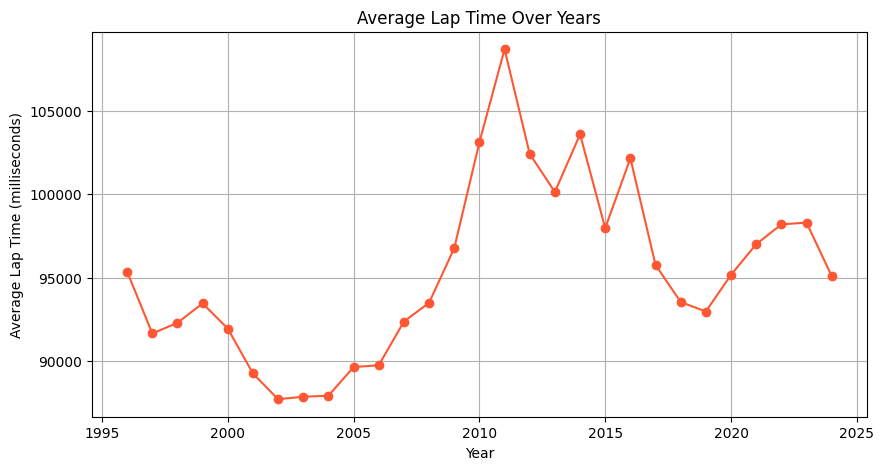

Trend Slope: 292.72565228421735 milliseconds per year


In [23]:
#Statistical tests
#1.ANOVA
#Objective: Determine if there are significant differences in average lap times across different circuits.


# Merge datasets to associate lap times with circuits
# Adding suffixes to handle overlapping column names
merged_data = pd.merge(lap_times, races, on='raceId', suffixes=('_lap', '_race'))
merged_data = pd.merge(merged_data, circuits, on='circuitId', suffixes=('', '_circuit'))

# Verify the columns in the merged DataFrame
print("Columns in merged_data:", merged_data.columns)

# Ensure the 'name' column from circuits is correctly referenced
# If there's a suffix, adjust the column name accordingly
if 'name' not in merged_data.columns:
    circuit_name_col = [col for col in merged_data.columns if 'name' in col and 'circuit' in col]
    if circuit_name_col:
        circuit_name_col = circuit_name_col[0]
    else:
        raise KeyError("Circuit name column not found in merged_data.")
else:
    circuit_name_col = 'name'

# Group lap times by circuit name
grouped_lap_times = merged_data.groupby(circuit_name_col)['milliseconds'].apply(list)

# Perform one-way ANOVA
anova_result = f_oneway(*grouped_lap_times)

print(f'F-statistic: {anova_result.statistic}, P-value: {anova_result.pvalue}')

# Time Series Analysis

# Convert race date to datetime
merged_data['date'] = pd.to_datetime(merged_data['date'])

# Extract year from date
merged_data['year'] = merged_data['date'].dt.year

# Calculate average lap time per year
avg_lap_time_per_year = merged_data.groupby('year')['milliseconds'].mean()

# Plot average lap time over years
plt.figure(figsize=(10, 5))
plt.plot(avg_lap_time_per_year.index, avg_lap_time_per_year.values, marker='o',color='#FF5733')
plt.xlabel('Year')
plt.ylabel('Average Lap Time (milliseconds)')
plt.title('Average Lap Time Over Years')
plt.grid(True)
plt.show()

# Perform linear regression to assess trend
X = sm.add_constant(avg_lap_time_per_year.index)  # Add constant term for intercept
y = avg_lap_time_per_year.values
model = sm.OLS(y, X).fit()
trend_slope = model.params[1]

print(f'Trend Slope: {trend_slope} milliseconds per year')

ADF Statistic: -1.6349245642629129
p-value: 0.46491406718652395
                               SARIMAX Results                                
Dep. Variable:           milliseconds   No. Observations:                   28
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -265.914
Date:                Sun, 23 Feb 2025   AIC                            537.829
Time:                        14:54:57   BIC                            541.825
Sample:                             0   HQIC                           539.050
                                 - 28                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.4699    684.036     -0.014      0.989   -1350.155    1331.215
ar.L1         -0.0361      0.170     -0.212      0.832      -0.370 

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


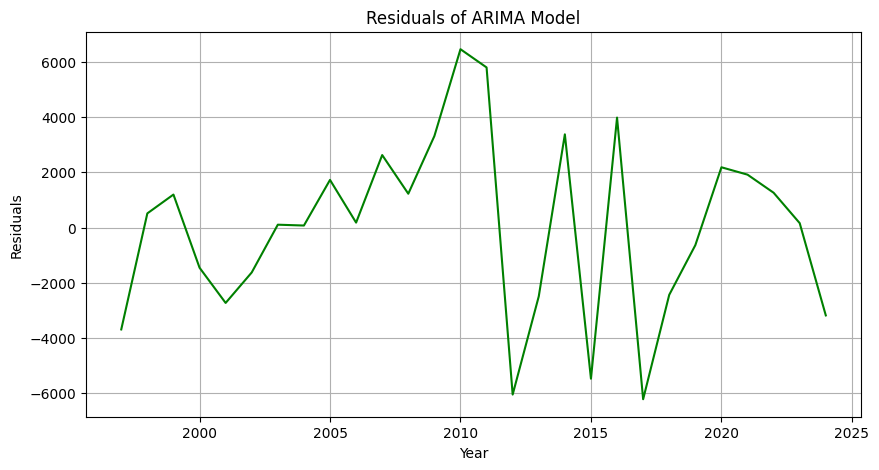

In [24]:
#2.Time Series Analysis
#Objective: Analyze trends in average lap times over the years to identify performance changes or technological advancements.



# Assuming 'lap_times' and 'races' DataFrames are already loaded

# Merge datasets to associate lap times with race years
merged_data = pd.merge(lap_times, races, on='raceId')

# Convert race date to datetime
merged_data['date'] = pd.to_datetime(merged_data['date'])

# Extract year from date
merged_data['year'] = merged_data['date'].dt.year

# Calculate average lap time per year
avg_lap_time_per_year = merged_data.groupby('year')['milliseconds'].mean()

# Check for stationarity using Augmented Dickey-Fuller test
adf_result = adfuller(avg_lap_time_per_year)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# If the series is not stationary, difference the data
if adf_result[1] > 0.05:
    avg_lap_time_per_year_diff = avg_lap_time_per_year.diff().dropna()
else:
    avg_lap_time_per_year_diff = avg_lap_time_per_year

# Fit ARIMA model
model = sm.tsa.ARIMA(avg_lap_time_per_year_diff, order=(1, 0, 0))  # ARIMA(p,d,q)
fitted_model = model.fit()

# Print model summary
print(fitted_model.summary())

# Plot the residuals to check for patterns
residuals = fitted_model.resid
plt.figure(figsize=(10, 5))
plt.plot(residuals,color='green')
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.title('Residuals of ARIMA Model')
plt.grid(True)
plt.show()

In [25]:
#3.Chi-square test
#Objective: Determine if a driver's nationality is associated with their likelihood of winning a race.

# Merge datasets to associate drivers with their race results
merged_data = pd.merge(results, drivers, on='driverId')

# Create a new column indicating win status
merged_data['win'] = merged_data['positionOrder'] == 1

# Create a contingency table
contingency_table = pd.crosstab(merged_data['nationality'], merged_data['win'])

# Perform the Chi-Square Test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f'Chi-square Statistic: {chi2_stat}')
print(f'P-value: {p_value}')
print(f'Degrees of Freedom: {dof}')

Chi-square Statistic: 480.8619505031474
P-value: 7.134749475232339e-76
Degrees of Freedom: 42


## Feature Engineering

In [66]:
import pandas as pd
import numpy as np
from scipy.stats import linregress

# ---------------------- HELPER FUNCTIONS ---------------------- #
def parse_quali_time(s):
    """
    Convert a qualifying time string to a timedelta.
    If the time is in 'm:ss.SSS' format, it prepends '00:' to convert it to 'hh:mm:ss.SSS'.
    """
    if pd.isnull(s):
        return pd.NaT
    if str(s).count(':') == 1:
        s = "00:" + s  # Prepend '00:' for hours
    try:
        return pd.to_timedelta(s)
    except Exception:
        return pd.NaT

def classify_circuits(data):
    """
    Example classification of circuits.
    For simplicity, classify circuits as 'high' if altitude > 50, otherwise 'low'.
    """
    if 'circuits' not in data:
        raise KeyError("The data dictionary must include a 'circuits' DataFrame.")
    circuits = data['circuits'].copy()
    circuits['circuit_type'] = circuits['alt'].apply(lambda x: 'high' if x > 50 else 'low')
    return circuits[['circuitId', 'circuit_type']]

# ---------------------- DRIVER CONSISTENCY FEATURES ---------------------- #
def calculate_driver_consistency(data):
    """
    Calculate enhanced driver consistency metrics:
      - Average and standard deviation of finishing positions.
      - Points consistency and fastest lap frequency.
      - Qualifying progression (improvement from Q1 to Q3).
    """
    results_df = pd.merge(
        data['results'],
        data['races'][['raceId', 'year', 'circuitId']],
        on='raceId'
    )

    # Convert key columns to numeric
    for col in ['position', 'points', 'grid', 'fastestLap']:
        results_df[col] = pd.to_numeric(results_df[col], errors='coerce')

    dnf_statuses = data['status'][data['status']['status'].str.contains('Accident|Mechanical|Retired', na=False)]['statusId']
    results_df['is_dnf'] = results_df['statusId'].isin(dnf_statuses)

    # Teammate performance: operate on only the 'position' Series to avoid grouping warnings.
    def get_teammate_performance(pos_series):
        if len(pos_series) < 2:
            return np.nan
        driver_pos = pd.to_numeric(pos_series.iloc[0], errors='coerce')
        teammate_pos = pd.to_numeric(pos_series.iloc[1], errors='coerce')
        if pd.isna(driver_pos) or pd.isna(teammate_pos):
            return np.nan
        return driver_pos - teammate_pos

    teammate_df = results_df[['raceId', 'constructorId', 'position']].copy()
    teammate_performance = teammate_df.groupby(['raceId', 'constructorId'])['position'].apply(get_teammate_performance)

    # Qualifying progression
    qual_progression = data['qualifying'].copy()
    qual_progression['q1_time'] = qual_progression['q1'].apply(parse_quali_time)
    qual_progression['q2_time'] = qual_progression['q2'].apply(parse_quali_time)
    qual_progression['q3_time'] = qual_progression['q3'].apply(parse_quali_time)
    qual_progression['quali_improvement'] = (qual_progression['q1_time'] - qual_progression['q3_time']).dt.total_seconds()

    driver_metrics = results_df.groupby(['driverId', 'year']).agg({
        'position': ['mean', 'std', 'count'],
        'is_dnf': 'mean',
        'points': ['sum', 'mean'],
        'grid': lambda x: np.percentile(pd.to_numeric(x, errors='coerce').dropna(), [25, 50, 75]).tolist(),
        'fastestLap': 'count'
    }).reset_index()

    driver_metrics.columns = [
        'driverId', 'year', 'avg_finish', 'std_finish', 'races_count',
        'dnf_rate', 'points_sum', 'points_avg', 'grid_percentiles', 'fastest_lap_count'
    ]

    return driver_metrics

# ---------------------- TEAM STRENGTH FEATURES ---------------------- #
def calculate_team_strength(data):
    """
    Calculate enhanced team strength metrics:
      - Points accumulation patterns.
      - Reliability rate (proportion of races not disqualified).
      - Car development trend (slope of points vs. round).
    """
    constructor_data = pd.merge(
        data['constructor_results'],
        data['races'][['raceId', 'year', 'circuitId', 'round']],
        on='raceId'
    )

    for col in ['points', 'round']:
        constructor_data[col] = pd.to_numeric(constructor_data[col], errors='coerce')

    def calculate_development_trend(grp):
        points = grp['points']
        rounds = grp['round']
        if len(points) < 2:
            return np.nan
        slope, _, _, _, _ = linregress(rounds, points)
        return slope

    # Group only on the required columns to mitigate deprecation warnings.
    trend_df = constructor_data[['constructorId', 'year', 'points', 'round']].groupby(['constructorId', 'year']).apply(calculate_development_trend).reset_index(name='development_trend')

    circuit_types = classify_circuits(data)
    constructor_data = pd.merge(constructor_data, circuit_types, on='circuitId', how='left')

    team_metrics_agg = constructor_data.groupby(['constructorId', 'year']).agg({
        'points': ['sum', 'mean'],
        'circuit_type': lambda x: x.value_counts().to_dict(),
        'status': lambda x: (x != 'D').mean()
    }).reset_index()
    team_metrics_agg.columns = ['constructorId', 'year', 'points_sum', 'points_avg', 'circuit_type_distribution', 'reliability_rate']

    team_metrics = pd.merge(team_metrics_agg, trend_df, on=['constructorId', 'year'], how='left')

    return team_metrics

# ---------------------- TRACK COMPLEXITY FEATURES ---------------------- #
def calculate_track_complexity(data):
    """
    Calculate enhanced track complexity metrics:
      - Lap time variability.
      - Sector variability.
      - Tire degradation estimation.
      - DRS impact (estimated via position changes).
    """
    lap_data = pd.merge(
        data['lap_times'],
        data['races'][['raceId', 'circuitId', 'year']],
        on='raceId'
    )

    for col in ['milliseconds', 'lap', 'position']:
        lap_data[col] = pd.to_numeric(lap_data[col], errors='coerce')

    def calculate_sector_variability(x):
        return x.std() / x.mean() if x.mean() != 0 else np.nan

    # Modified tire degradation estimator: check if 'lap' values are unique.
    def estimate_tire_deg(grp):
        lap_numbers = grp['lap']
        lap_times = grp['milliseconds']
        if len(grp) < 2 or lap_numbers.nunique() < 2:
            return np.nan
        slope, _, _, _, _ = linregress(lap_numbers, lap_times)
        return slope

    def calculate_drs_impact(x):
        return x.diff().abs().mean()

    track_metrics = lap_data.groupby(['circuitId', 'year']).agg(
        lap_time_mean=('milliseconds', 'mean'),
        lap_time_std=('milliseconds', 'std'),
        sector_variability=('milliseconds', calculate_sector_variability),
        drs_impact=('position', calculate_drs_impact),
        tire_degradation=('lap', lambda x: estimate_tire_deg(pd.DataFrame({
            'lap': x,
            'milliseconds': lap_data.loc[x.index, 'milliseconds']
        })))
    ).reset_index()

    return track_metrics

# ---------------------- EXAMPLE USAGE ---------------------- #
# Ensure your data dictionary includes all required keys:
# 'results', 'races', 'status', 'qualifying', 'constructor_results',
# 'pit_stops', 'lap_times', 'drivers', and 'circuits'.
data = {
    'results': results,
    'races': races,
    'status': status,
    'qualifying': qualifying,
    'constructor_results': constructor_results,
    'pit_stops': pit_stops,
    'lap_times': lap_times,
    'drivers': drivers,
    'circuits': circuits
}

# Compute engineered features:
driver_features = calculate_driver_consistency(data)
team_features = calculate_team_strength(data)
track_features = calculate_track_complexity(data)

print("Driver Features:")
print(driver_features.head())
print("\nTeam Features:")
print(team_features.head())
print("\nTrack Complexity Features:")
print(track_features.head())

<ipython-input-66-0f17a8a984d1>:113: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Driver Features:
   driverId  year  avg_finish  std_finish  races_count  dnf_rate  points_sum  \
0         1  2007    3.000000    2.280351           16  0.000000       109.0   
1         1  2008    4.411765    3.922034           17  0.000000        98.0   
2         1  2009    7.642857    5.719160           14  0.058824        49.0   
3         1  2010    3.750000    3.235223           16  0.000000       240.0   
4         1  2011    3.750000    2.144761           16  0.000000       227.0   

   points_avg  grid_percentiles  fastest_lap_count  
0    6.411765   [1.0, 2.0, 4.0]                 17  
1    5.444444   [1.0, 2.5, 4.0]                 18  
2    2.882353  [3.0, 9.0, 16.0]                 16  
3   12.631579   [3.0, 4.0, 5.5]                 18  
4   11.947368   [2.0, 3.0, 4.0]                 19  

Team Features:
   constructorId  year  points_sum  points_avg circuit_type_distribution  \
0              1  1968         0.0    0.000000               {'high': 2}   
1              1

## 1. Driver & Constructor Performance


*   Identify dominant drivers and constructors by analyzing win ratios and podium finishes.

*   Assess the relationship between career longevity and success metrics (wins, podiums, points).




In [28]:
#1
results = results.merge(races[['raceId', 'year']], on='raceId', how='left')


driver_wins = results[results['positionOrder'] == 1].groupby('driverId').size()  #tot no of race won by the drivers
total_races = results.groupby('driverId').size() # tot no of races attended
win_ratio = (driver_wins / total_races).fillna(0)

podiums = results[results['positionOrder'] <= 3].groupby('driverId').size() # tot no of top 3 pla


career_span = results.groupby('driverId')['year'].agg(['min', 'max'])
career_span['years_active'] = career_span['max'] - career_span['min'] + 1


total_points = results.groupby('driverId')['points'].sum()

driver_performance = pd.DataFrame({
    'win_ratio': win_ratio,
    'podiums': podiums,
    'career_years': career_span['years_active'],
    'total_points': total_points
}).fillna(0)


driver_performance = driver_performance.merge(drivers[['driverId', 'forename', 'surname']], on='driverId')
driver_performance['Driver Name'] = driver_performance['forename'] + " " + driver_performance['surname']
driver_performance.drop(columns=['forename', 'surname'], inplace=True)




constructor_wins = results[results['positionOrder'] == 1].groupby('constructorId').size()
total_races_constructor = results.groupby('constructorId').size()
constructor_win_ratio = (constructor_wins / total_races_constructor).fillna(0)


constructor_podiums = results[results['positionOrder'] <= 3].groupby('constructorId').size()


constructor_total_points = results.groupby('constructorId')['points'].sum()


constructor_performance = pd.DataFrame({
    'win_ratio': constructor_win_ratio,
    'podiums': constructor_podiums,
    'total_points': constructor_total_points
}).fillna(0)


constructor_performance = constructor_performance.merge(constructors[['constructorId', 'name']], on='constructorId')

print("\nTop 10 Drivers by Win Ratio:")
print(driver_performance.sort_values(by='win_ratio', ascending=False).head(10))

print("\nTop 10 Constructors by Win Ratio:")
print(constructor_performance.sort_values(by='win_ratio', ascending=False).head(10))


print("\nCareer Longevity vs Success Metrics:")
print(driver_performance[['career_years', 'win_ratio', 'podiums', 'total_points']].corr())



Top 10 Drivers by Win Ratio:
     driverId  win_ratio  podiums  career_years  total_points  \
765       766   0.500000      1.0             2          9.00   
578       579   0.413793     35.0             9        279.14   
656       657   0.400000      2.0             5         19.00   
646       647   0.361111     17.0             6        140.00   
372       373   0.342466     32.0             9        274.00   
828       830   0.301435    112.0            10       2912.50   
29         30   0.295455    155.0            22       1566.00   
0           1   0.294944    202.0            18       4820.50   
327       328   0.270000     43.0             9        360.00   
101       102   0.253086     80.0            11        614.00   

            Driver Name  
765         Lee Wallard  
578         Juan Fangio  
656       Bill Vukovich  
646      Alberto Ascari  
372           Jim Clark  
828      Max Verstappen  
29   Michael Schumacher  
0        Lewis Hamilton  
327      Jackie Stew

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


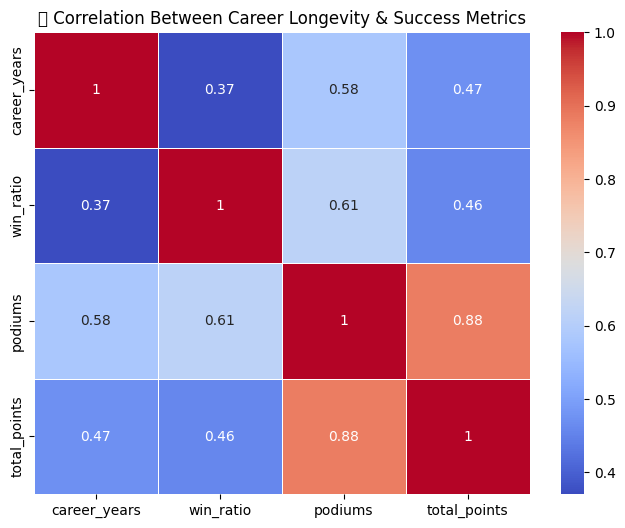

In [29]:
#1 Heatmap between Career longetivity and success metrics
plt.figure(figsize=(8,6))
sns.heatmap(
    driver_performance[['career_years', 'win_ratio', 'podiums', 'total_points']].corr(),
    annot=True, cmap='coolwarm', linewidths=0.5
)
plt.title("📊 Correlation Between Career Longevity & Success Metrics")
plt.show()



## 2. Qualifying vs. Race Performance



*   How does starting grid position impact final race results?

*    Do certain drivers excel at making up positions?




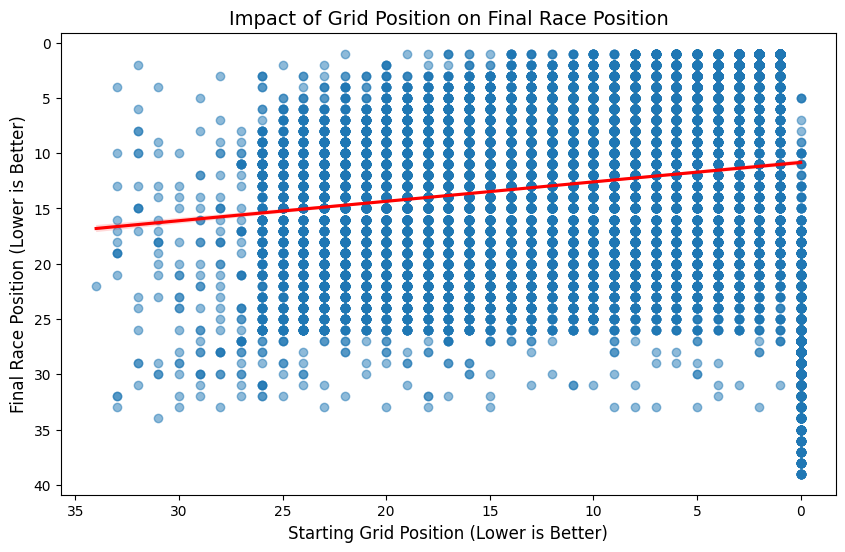

In [30]:
#2 Analysing trends
#Starting at the front (lower grid positions) improves chances of winning
#Other race factors (pit stops, weather, car reliability) influence final results beyond just starting position

plt.figure(figsize=(10, 6))
sns.regplot(x=results['grid'], y=results['positionOrder'], scatter_kws={'alpha':0.5}, line_kws={"color": "red"})


plt.title("Impact of Grid Position on Final Race Position", fontsize=14)
plt.xlabel("Starting Grid Position (Lower is Better)", fontsize=12)
plt.ylabel("Final Race Position (Lower is Better)", fontsize=12)
plt.gca().invert_xaxis()  # Lower grid positions (better) should be on the left
plt.gca().invert_yaxis()  # Lower finish positions (better) should be on the top

plt.show()

In [31]:
#2
qualifying_results = qualifying[['raceId', 'driverId', 'position']].rename(columns={'position': 'grid_position'})
race_results = results[['raceId', 'driverId', 'positionOrder']].rename(columns={'positionOrder': 'final_position'})

merged_data = pd.merge(qualifying_results, race_results, on=['raceId', 'driverId'])
print("\n\nMerged data ", merged_data.head(5))
print("\n\n")

# Calculate positions gained/lost during the race
merged_data['positions_gained'] = merged_data['grid_position'] - merged_data['final_position']

# Group by driverId to find average positions gained per driver
driver_performance = merged_data.groupby('driverId')['positions_gained'].mean().sort_values(ascending=False)

# Display top drivers who gained most positions
print(driver_performance.head(10))

# Analyze correlation between grid position and final position
correlation = merged_data[['grid_position', 'final_position']].corr().iloc[0,1]
print(f"\n\nCorrelation between grid position and final race position: {correlation:.2f}")



Merged data     raceId  driverId  grid_position  final_position
0      18         1              1               1
1      18         9              2               9
2      18         5              3               5
3      18        13              4              13
4      18         2              5               2



driverId
111    11.000000
101     8.733333
82      8.666667
98      7.666667
60      7.500000
107     7.500000
103     7.076923
113     7.000000
61      7.000000
53      6.600000
Name: positions_gained, dtype: float64


Correlation between grid position and final race position: 0.58


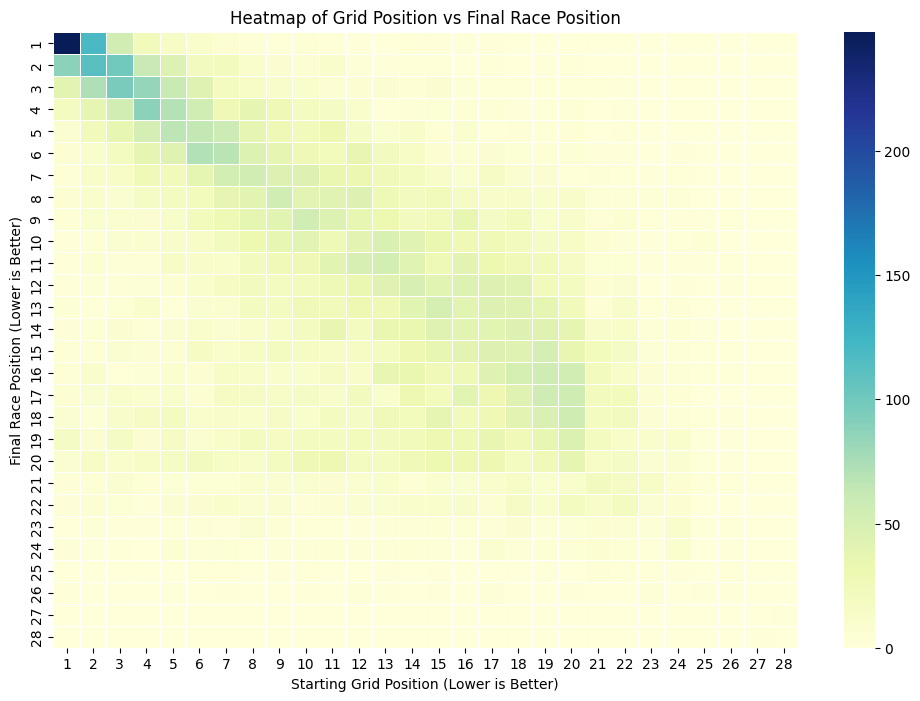

In [32]:
#2
#Strong Correlation Between Qualifying and Final Position
#Midfield and Lower Grid Positions Are More Unpredictable


heatmap_data = merged_data.pivot_table(index='final_position', columns='grid_position', aggfunc='size', fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=0.5, annot=False)

plt.xlabel("Starting Grid Position (Lower is Better)")
plt.ylabel("Final Race Position (Lower is Better)")
plt.title("Heatmap of Grid Position vs Final Race Position")

plt.show()


## 3. Pit Stop Strategies




*   Evaluate optimal pit stop frequency and timing for race success.

*   Analyze pit stop efficiency and its influence on race outcomes.









Average Pit Stops per Driver per Race: 2.09


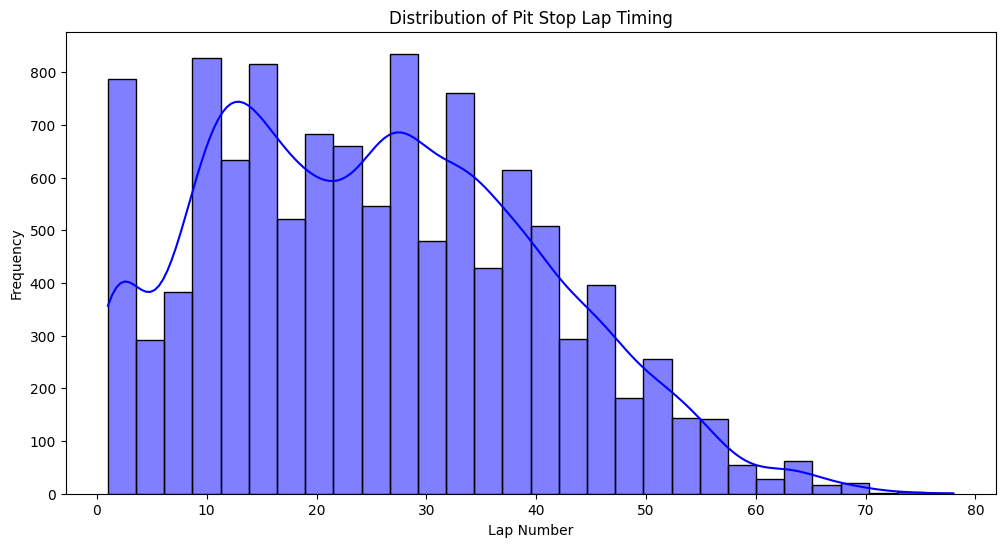

<ipython-input-33-5821a2de36f9>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=pit_stops['stop'], y=pit_stops['milliseconds'] / 1000, palette='coolwarm')


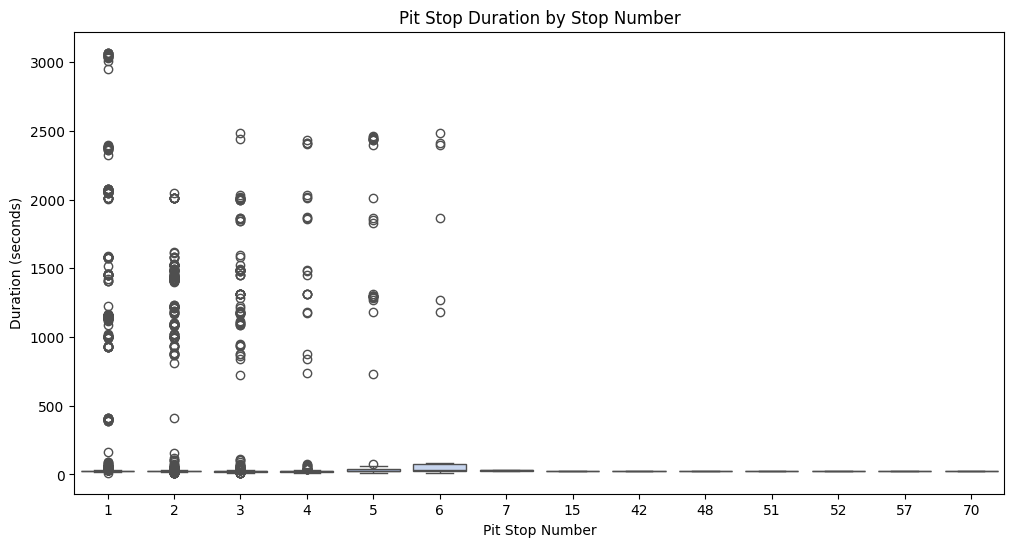


 Merged data 

    raceId  driverId  stop  lap    time_x  duration  milliseconds_x  resultId  \
0     841       153     1    1  17:05:23    26.898           26898     20789   
1     841        30     1    1  17:05:52    25.021           25021     20797   
2     841        17     1   11  17:20:48    23.426           23426     20783   
3     841         4     1   12  17:22:34    23.251           23251     20782   
4     841        13     1   13  17:24:10    23.842           23842     20785   

   constructorId number  ...  laps     time_y milliseconds_y  fastestLap  \
0              5     19  ...    57        NaN            NaN          41   
1            131      7  ...    19        NaN            NaN          13   
2              9      2  ...    58    +38.171        5408430          50   
3              6      5  ...    58    +31.772        5402031          49   
4              6      6  ...    58  +1:25.186        5455445          55   

   rank  fastestLapTime fastestLapSpeed statu

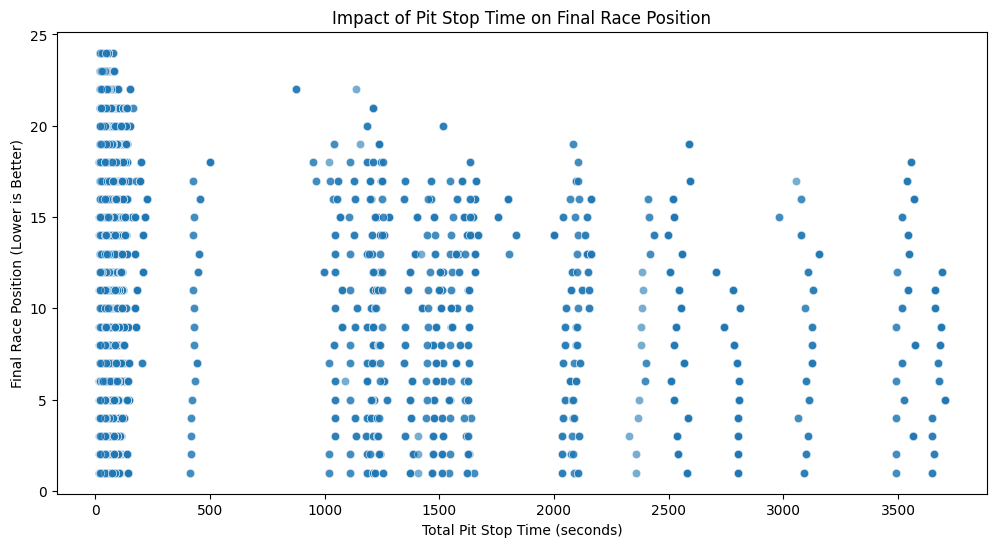

In [33]:
#3

#Pit Stop Frequency per Race
pit_stop_counts = pit_stops.groupby(['raceId', 'driverId'])['stop'].max().reset_index() #tot no of pit_stops by drivers
avg_pit_stops = pit_stop_counts['stop'].mean() # avg of pitstops by each driver
print(f"Average Pit Stops per Driver per Race: {avg_pit_stops:.2f}")

# Distribution of Pit Stop Lap Timing
plt.figure(figsize=(12, 6))
sns.histplot(pit_stops['lap'], bins=30, kde=True, color='blue')
plt.title('Distribution of Pit Stop Lap Timing')
plt.xlabel('Lap Number')
plt.ylabel('Frequency')
plt.show()

#Pit Stop Duration Analysis
plt.figure(figsize=(12, 6))
sns.boxplot(x=pit_stops['stop'], y=pit_stops['milliseconds'] / 1000, palette='coolwarm')
plt.title('Pit Stop Duration by Stop Number')
plt.xlabel('Pit Stop Number')
plt.ylabel('Duration (seconds)')
plt.show()

# Impact of Pit Stop Duration on Final Race Position
merged_data = pit_stops.merge(results, on=['raceId', 'driverId'])

merged_data['pit_stop_time'] = merged_data.groupby(['raceId', 'driverId'])['milliseconds_x'].transform('sum')
print("\n Merged data \n\n",merged_data.head(5))

plt.figure(figsize=(12, 6))
sns.scatterplot(x=merged_data['pit_stop_time'] / 1000, y=merged_data['positionOrder'], alpha=0.6)
plt.title('Impact of Pit Stop Time on Final Race Position')
plt.xlabel('Total Pit Stop Time (seconds)')
plt.ylabel('Final Race Position (Lower is Better)')
plt.show()


## 4. Head-to-Head Driver Analysis:



*    Which rivalries have been the most competitive?
*    Identify head-to-head stats based on race finishes.





<ipython-input-34-5deb883601a2>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  driver_comparisons = race_results.groupby('raceId').apply(get_driver_pairs).reset_index(drop=True)


Top 10 Most Competitive Driver Rivalries:
winner           1  2  3  4  5  6  7  8  9  10  ...  857  858  859  860  861  \
driver1 driver2                                 ...                            
344     320      0  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0   
482     566      0  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0   
        567      0  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0   
        568      0  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0   
        577      0  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0   
        579      0  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0   
        580      0  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0   
        554      0  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0   
        581      0  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0   
        586      0  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0  

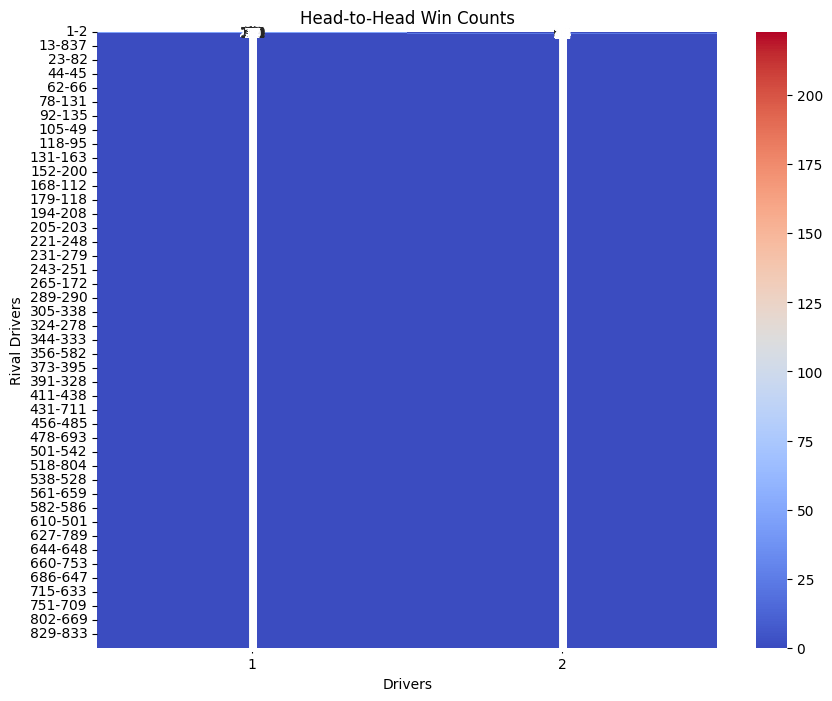

In [34]:
#4
#Head-to-Head Driver Analysis: compare two drivers directly

race_results = results[['raceId', 'driverId', 'positionOrder']]

# Create driver pairs per race
def get_driver_pairs(group):
    drivers = group[['driverId', 'positionOrder']].values
    pairs = list(combinations(drivers, 2))  # Get all driver pairs in the race
    return pd.DataFrame([(group.name, d1[0], d2[0], d1[1], d2[1]) for d1, d2 in pairs],
                        columns=['raceId', 'driver1', 'driver2', 'pos1', 'pos2'])

# Apply function to group races
driver_comparisons = race_results.groupby('raceId').apply(get_driver_pairs).reset_index(drop=True)

# Determine head-to-head winners
driver_comparisons['winner'] = driver_comparisons.apply(lambda x: x['driver1'] if x['pos1'] < x['pos2'] else x['driver2'], axis=1)

# Count head-to-head wins
head_to_head = driver_comparisons.groupby(['driver1', 'driver2'])['winner'].value_counts().unstack(fill_value=0)

# Calculate win ratio
head_to_head['total_races'] = head_to_head.sum(axis=1)
head_to_head['win_ratio_driver1'] = head_to_head.iloc[:, 0] / head_to_head['total_races']
head_to_head['win_ratio_driver2'] = head_to_head.iloc[:, 1] / head_to_head['total_races']

# Sort by most competitive rivalries (closest win ratios)
head_to_head['competitiveness'] = abs(head_to_head['win_ratio_driver1'] - head_to_head['win_ratio_driver2'])
most_competitive = head_to_head.sort_values('competitiveness', ascending=True)

# Display the top 10 closest rivalries
print("Top 10 Most Competitive Driver Rivalries:")
print(most_competitive.head(20))

# Visualization: Heatmap of Rivalry Wins
plt.figure(figsize=(10, 8))
sns.heatmap(head_to_head.iloc[:, :2], cmap="coolwarm", annot=True, fmt="d")
plt.xlabel("Drivers")
plt.ylabel("Rival Drivers")
plt.title("Head-to-Head Win Counts")
plt.show()



In [35]:
#4
race_results = results[['raceId', 'driverId', 'positionOrder']]
head_to_head = race_results[race_results['positionOrder'] <= 2]  # Keep only top 2 finishers

#  Pair drivers who finished in top 2 for each race
paired_drivers = head_to_head.merge(head_to_head, on="raceId")
paired_drivers = paired_drivers[paired_drivers["driverId_x"] < paired_drivers["driverId_y"]]  # Avoid duplicates

# Determine the winner for each race
paired_drivers["winner"] = np.where(
    paired_drivers["positionOrder_x"] < paired_drivers["positionOrder_y"],
    paired_drivers["driverId_x"],
    paired_drivers["driverId_y"]
)

# Count wins for each driver pairing
head_to_head_counts = paired_drivers.groupby(["driverId_x", "driverId_y", "winner"]).size().unstack(fill_value=0)

#  Ensure all matchups are counted
head_to_head_counts["total_races"] = head_to_head_counts.sum(axis=1)

# Calculate win ratios for each driver
head_to_head_counts["win_ratio_driver1"] = head_to_head_counts.iloc[:, 0] / head_to_head_counts["total_races"]
head_to_head_counts["win_ratio_driver2"] = head_to_head_counts.iloc[:, 1] / head_to_head_counts["total_races"]

#  Compute competitiveness as absolute difference
head_to_head_counts["competitiveness"] = abs(head_to_head_counts["win_ratio_driver1"] - head_to_head_counts["win_ratio_driver2"])

# Filter and display the most competitive rivalries
competitive_rivalries = head_to_head_counts.sort_values("competitiveness").head(10)
print("Top 10 Most Competitive Driver Rivalries:")
print(competitive_rivalries)


Top 10 Most Competitive Driver Rivalries:
winner                 1  3  4  5  8  9  13  14  15  17  ...  839  842  844  \
driverId_x driverId_y                                    ...                  
178        223         0  0  0  0  0  0   0   0   0   0  ...    0    0    0   
289        370         0  0  0  0  0  0   0   0   0   0  ...    0    0    0   
           364         0  0  0  0  0  0   0   0   0   0  ...    0    0    0   
           361         0  0  0  0  0  0   0   0   0   0  ...    0    0    0   
           360         0  0  0  0  0  0   0   0   0   0  ...    0    0    0   
           356         0  0  0  0  0  0   0   0   0   0  ...    0    0    0   
           341         0  0  0  0  0  0   0   0   0   0  ...    0    0    0   
           328         0  0  0  0  0  0   0   0   0   0  ...    0    0    0   
           304         0  0  0  0  0  0   0   0   0   0  ...    0    0    0   
278        358         0  0  0  0  0  0   0   0   0   0  ...    0    0    0   

winner   

In [36]:
#4

race_results = results[['raceId', 'driverId', 'positionOrder']]

#  Find all drivers who competed in the same race
paired_drivers = race_results.merge(race_results, on="raceId")

# Remove self-comparisons (same driver)
paired_drivers = paired_drivers[paired_drivers["driverId_x"] != paired_drivers["driverId_y"]]

# Ensure each pair is unique (avoid flipped pairs)
paired_drivers = paired_drivers[paired_drivers["driverId_x"] < paired_drivers["driverId_y"]]

# Determine the winner for each race
paired_drivers["winner"] = np.where(
    paired_drivers["positionOrder_x"] < paired_drivers["positionOrder_y"],
    paired_drivers["driverId_x"],
    paired_drivers["driverId_y"]
)

# Count wins for each driver in the matchup
paired_drivers["wins_driver1"] = (paired_drivers["winner"] == paired_drivers["driverId_x"]).astype(int)
paired_drivers["wins_driver2"] = (paired_drivers["winner"] == paired_drivers["driverId_y"]).astype(int)

#  Group by driver pairs
head_to_head_counts = paired_drivers.groupby(["driverId_x", "driverId_y"])[["wins_driver1", "wins_driver2"]].sum()

#  Calculate total races and win ratios
head_to_head_counts["total_races"] = head_to_head_counts["wins_driver1"] + head_to_head_counts["wins_driver2"]
head_to_head_counts["win_ratio_driver1"] = head_to_head_counts["wins_driver1"] / head_to_head_counts["total_races"]
head_to_head_counts["win_ratio_driver2"] = head_to_head_counts["wins_driver2"] / head_to_head_counts["total_races"]

# Compute competitiveness score
head_to_head_counts["competitiveness"] = 1 - abs(head_to_head_counts["win_ratio_driver1"] - head_to_head_counts["win_ratio_driver2"])

# Filter for at least 5 head-to-head races
head_to_head_counts = head_to_head_counts[head_to_head_counts["total_races"] >= 5]

#  Sort by competitiveness (highest = most competitive)
competitive_rivalries = head_to_head_counts.sort_values("competitiveness", ascending=False).head(50)

print("\nTop 10 Most Competitive Driver Rivalries:")
print(competitive_rivalries)




Top 10 Most Competitive Driver Rivalries:
                       wins_driver1  wins_driver2  total_races  \
driverId_x driverId_y                                            
231        298                    4             4            8   
172        187                   70            70          140   
238        345                    7             7           14   
626        689                    3             3            6   
427        624                    4             4            8   
           663                    7             7           14   
           670                    6             6           12   
182        317                    6             6           12   
341        359                    6             6           12   
626        640                    6             6           12   
429        554                    4             4            8   
625        627                    3             3            6   
179        180                   

## 5. Hypothetical Driver Swaps:


*   Swap two drivers between different teams and predict the impact on team and driver standings.




In [37]:
#5


# Merge datasets
data = results[['raceId', 'driverId', 'constructorId', 'grid', 'fastestLapTime', 'points']]
data = data.merge(qualifying[['raceId', 'driverId', 'position']], on=['raceId', 'driverId'], how='left')
data.rename(columns={'position': 'qualifying_position'}, inplace=True)

# Convert fastestLapTime to numerical values
def time_to_ms(time_str):
    try:
        m, s = time_str.split(':')
        return int(m) * 60000 + float(s) * 1000
    except:
        return np.nan  # Handle NaN values

data['fastestLapTime'] = data['fastestLapTime'].apply(time_to_ms)

# Fill missing values with median
data.fillna(data.median(), inplace=True)

# Encode categorical variables
encoder = LabelEncoder()
data['driverId'] = encoder.fit_transform(data['driverId'])
data['constructorId'] = encoder.fit_transform(data['constructorId'])

# Define features and target variable
X = data[['driverId', 'constructorId', 'grid', 'qualifying_position', 'fastestLapTime']]
y = data['points']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)


r2 = r2_score(y_test, y_pred)

print(f"Model Performance\n R² Score: {r2:.3f}")




Model Performance
 R² Score: 0.521



Impact of Driver Swap:
          original_points  new_points  point_change
driverId                                           
1                   259.0  765.082571    506.082571
5                     9.0   76.973056     67.973056


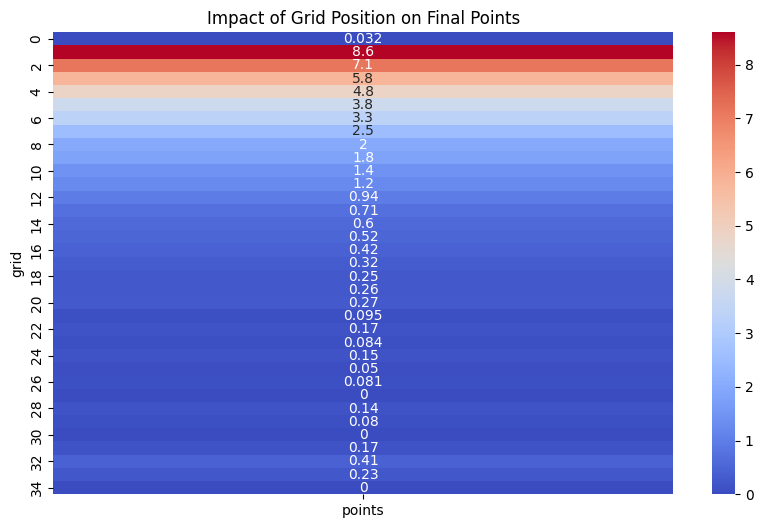

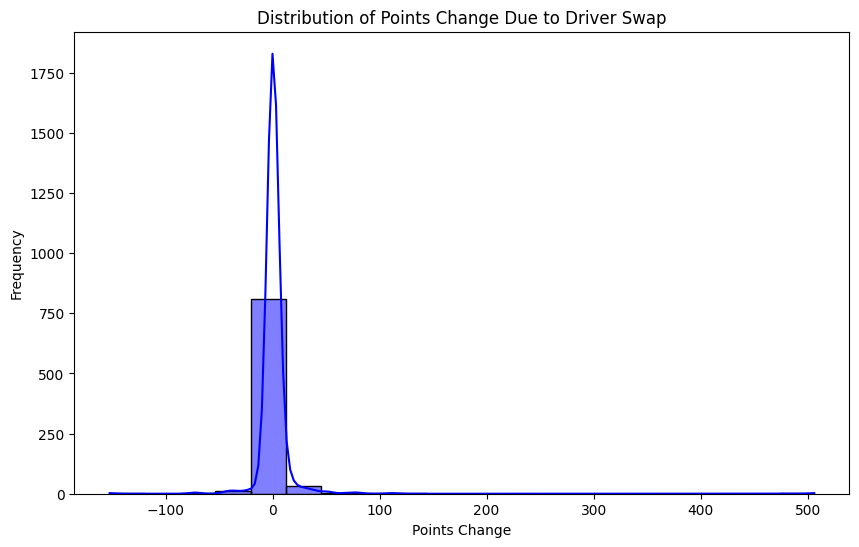

In [38]:
#5
# -------- DRIVER SWAP ANALYSIS -------- #

# Select two drivers
driver_1 = 1
driver_2 = 5

# Get their current teams
team_1 = results.loc[results['driverId'] == driver_1, 'constructorId'].mode()[0]
team_2 = results.loc[results['driverId'] == driver_2, 'constructorId'].mode()[0]

# Create swapped dataset
swapped_data = data.copy()
swapped_data.loc[swapped_data['driverId'] == driver_1, 'constructorId'] = team_2
swapped_data.loc[swapped_data['driverId'] == driver_2, 'constructorId'] = team_1

# Predict new points after swap
swapped_data['predicted_points'] = model.predict(swapped_data[['driverId', 'constructorId', 'grid', 'qualifying_position', 'fastestLapTime']])

# Compare original vs swapped driver points
original_points = data.groupby('driverId')['points'].sum()
new_points = swapped_data.groupby('driverId')['predicted_points'].sum()

comparison = pd.DataFrame({'original_points': original_points, 'new_points': new_points})
comparison['point_change'] = comparison['new_points'] - comparison['original_points']

print("\nImpact of Driver Swap:")
print(comparison.loc[[driver_1, driver_2]])



# Heatmap of grid position vs final points
plt.figure(figsize=(10,6))
sns.heatmap(data.pivot_table(index='grid', values='points', aggfunc='mean'), cmap="coolwarm", annot=True)
plt.title("Impact of Grid Position on Final Points")
plt.show()

# Distribution of point changes after driver swap
plt.figure(figsize=(10,6))
sns.histplot(comparison['point_change'], bins=20, kde=True, color="blue")
plt.title("Distribution of Points Change Due to Driver Swap")
plt.xlabel("Points Change")
plt.ylabel("Frequency")
plt.show()

<Figure size 800x500 with 0 Axes>

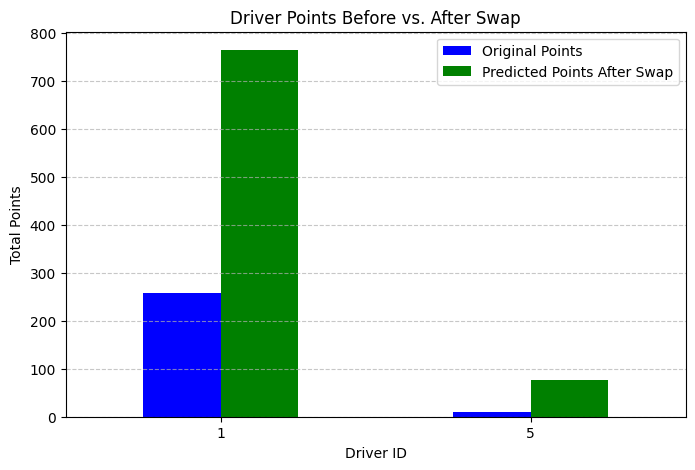

In [39]:
#5
#Plotting difference between original and predicted results

swapped_drivers = comparison.loc[[driver_1, driver_2]]

# Bar chart
plt.figure(figsize=(8,5))
swapped_drivers[['original_points', 'new_points']].plot(kind='bar', figsize=(8,5), color=['blue', 'green'])
plt.title("Driver Points Before vs. After Swap")
plt.xlabel("Driver ID")
plt.ylabel("Total Points")
plt.xticks(rotation=0)
plt.legend(["Original Points", "Predicted Points After Swap"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


##6. Driver Movements & Team Networks:

*   Map driver transitions across teams use network graph for visualizations.




In [40]:
#6

import networkx as nx

def swap_drivers_and_analyze(driver1_id, driver2_id, results, driver_standings, constructor_standings):
    # Swap drivers between teams in results dataset
    temp_team = results.loc[results['driverId'] == driver1_id, 'constructorId'].values[0]
    results.loc[results['driverId'] == driver1_id, 'constructorId'] = results.loc[results['driverId'] == driver2_id, 'constructorId'].values[0]
    results.loc[results['driverId'] == driver2_id, 'constructorId'] = temp_team

    # Recalculate driver standings
    new_driver_standings = results.groupby('driverId')['points'].sum().reset_index()
    driver_standings = driver_standings.drop(columns=['points']).merge(new_driver_standings, on='driverId', how='left')

    # Recalculate constructor standings
    new_constructor_standings = results.groupby('constructorId')['points'].sum().reset_index()
    constructor_standings = constructor_standings.drop(columns=['points']).merge(new_constructor_standings, on='constructorId', how='left')

    # Network Graph for Driver Transitions
    G = nx.DiGraph()
    for driver_id in results['driverId'].unique():
        teams = results[results['driverId'] == driver_id]['constructorId'].unique()
        for i in range(len(teams) - 1):
            G.add_edge(teams[i], teams[i + 1], driver=driver_id)

    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'Driver {d}' for u, v, d in G.edges(data='driver')})
    plt.title('Driver Transitions Across Teams')
    plt.show()

    return driver_standings, constructor_standings

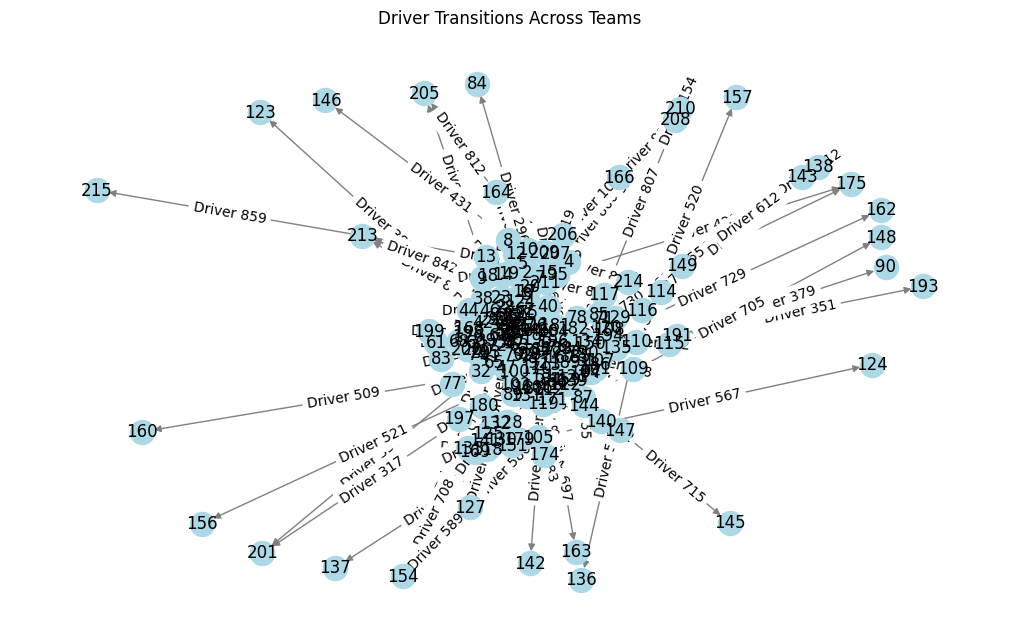

In [41]:
driver_standings_updated, constructor_standings_updated = swap_drivers_and_analyze(5, 8, results, driver_standings, constructor_standings)

##7. Team Performance Comparison:

*   Compare team success rates against different opponents with and without considering circuit factor.


Team Success Rate Analysis (2020-2023)

Overall Win Rates:
McLaren: 0.5% (1 wins in 203 races)
BMW Sauber: 0.0% (0 wins in 0 races)
Williams: 0.0% (0 wins in 166 races)
Renault: 0.0% (0 wins in 34 races)

Circuit Impact:

McLaren:
Best Circuit: Autodromo Nazionale di Monza (11.1% win rate)

BMW Sauber:
Best Circuit: Red Bull Ring (0.0% win rate)

Williams:
Best Circuit: Red Bull Ring (0.0% win rate)

Renault:
Best Circuit: Red Bull Ring (0.0% win rate)


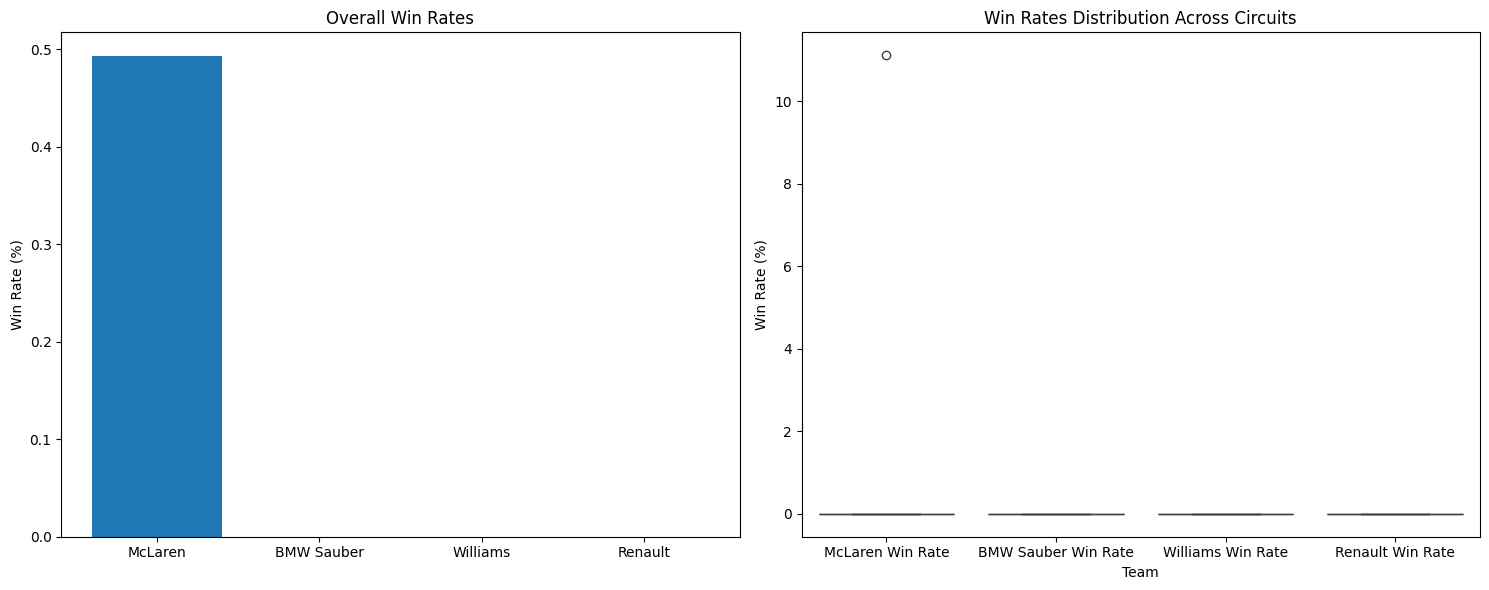

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def compare_team_success(team1_id, opponent_ids, year_start, year_end, races, results, circuits, constructors):

    # Ensure circuitId exists before merging
    if 'circuitId' not in races.columns:
        raise KeyError("'circuitId' is missing from races DataFrame. Check dataset structure.")

    # Get team names
    team1_name = constructors.loc[constructors['constructorId'] == team1_id, 'name'].values[0]
    opponent_names = {team_id: constructors.loc[constructors['constructorId'] == team_id, 'name'].values[0] for team_id in opponent_ids}

    # Merge race info with circuits if circuitId exists
    race_info = races.merge(circuits[['circuitId', 'name']], on='circuitId', how='left') if 'name' in circuits.columns else races.copy()

    # Merge results with race information, ensuring circuitId is correctly referenced
    full_data = results.merge(race_info[['raceId', 'year', 'circuitId']], on='raceId', how='left')

    # Check the column names to determine the correct circuitId column
    if 'circuitId_x' in full_data.columns:
        full_data.rename(columns={'circuitId_x': 'circuitId'}, inplace=True)
    elif 'circuitId_y' in full_data.columns:
        full_data.rename(columns={'circuitId_y': 'circuitId'}, inplace=True)
    # Proceed with filtering the data
    mask = (
        full_data['year'].between(year_start, year_end) &
        full_data['constructorId'].isin([team1_id] + opponent_ids)
    )

    analysis_data = full_data[mask].copy()


    # Overall success rate (without circuit consideration)
    overall_success = []
    teams = [team1_id] + opponent_ids
    team_names = [team1_name] + list(opponent_names.values())

    for team_id, team_name in zip(teams, team_names):
        wins = len(analysis_data[(analysis_data['constructorId'] == team_id) & (analysis_data['positionOrder'] == 1)])
        total_races = len(analysis_data[analysis_data['constructorId'] == team_id])
        win_rate = (wins / total_races * 100) if total_races > 0 else 0
        overall_success.append({'Team': team_name, 'Wins': wins, 'Total Races': total_races, 'Win Rate': win_rate})

    overall_success_df = pd.DataFrame(overall_success)

    # Circuit-specific success rates
    circuit_success = []
    if 'name' in race_info.columns:
        analysis_data = analysis_data.merge(race_info[['raceId', 'name']], on='raceId', how='left')

    for circuit_id in analysis_data['circuitId'].dropna().unique():
        circuit_data = analysis_data[analysis_data['circuitId'] == circuit_id]
        circuit_name = circuit_data['name'].iloc[0] if 'name' in circuit_data.columns else f'Circuit {circuit_id}'

        circuit_entry = {'Circuit': circuit_name}
        for team_id, team_name in zip(teams, team_names):
            team_wins = len(circuit_data[(circuit_data['constructorId'] == team_id) & (circuit_data['positionOrder'] == 1)])
            team_races = len(circuit_data[circuit_data['constructorId'] == team_id])
            circuit_entry[f'{team_name} Win Rate'] = (team_wins / team_races * 100) if team_races > 0 else 0

        circuit_success.append(circuit_entry)

    circuit_success_df = pd.DataFrame(circuit_success)

    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Overall success rates
    ax1.bar(overall_success_df['Team'], overall_success_df['Win Rate'])
    ax1.set_title('Overall Win Rates')
    ax1.set_ylabel('Win Rate (%)')

    # Circuit-specific comparison
    circuit_comparison = pd.melt(circuit_success_df, id_vars=['Circuit'], var_name='Team', value_name='Win Rate')
    sns.boxplot(data=circuit_comparison, x='Team', y='Win Rate', ax=ax2)
    ax2.set_title('Win Rates Distribution Across Circuits')
    ax2.set_ylabel('Win Rate (%)')

    plt.tight_layout()

    # Print summary
    print(f"\nTeam Success Rate Analysis ({year_start}-{year_end})")
    print("\nOverall Win Rates:")
    for _, row in overall_success_df.iterrows():
        print(f"{row['Team']}: {row['Win Rate']:.1f}% ({row['Wins']} wins in {row['Total Races']} races)")

    print("\nCircuit Impact:")
    for team in team_names:
        best_circuit = circuit_success_df.loc[circuit_success_df[f'{team} Win Rate'].idxmax()]
        print(f"\n{team}:")
        print(f"Best Circuit: {best_circuit['Circuit']} ({best_circuit[f'{team} Win Rate']:.1f}% win rate)")

    return fig

# Example function call
fig = compare_team_success(
    team1_id=1,    # Replace with actual team ID
    opponent_ids=[2, 3, 4],    # Replace with actual opponent team IDs
    year_start=2020,
    year_end=2023,
    races=races,
    results=results,
    circuits=circuits,
    constructors=constructors
)

plt.show()


## 8. Driver Consistency in Race Performance:



*   Identify drivers with consistent top finishes and those with fluctuating results.


In [46]:
'''Driver Consistency in Race Performance:
Identify drivers with consistent top finishes and those with fluctuating results.
'''

# Merge race results with driver details
driver_consistency = results.merge(drivers, on='driverId', how='left')

# Aggregate driver performance
driver_consistency = driver_consistency.groupby(['driverId', 'forename', 'surname']).agg(
    avg_position=('positionOrder', 'mean'),
    position_std=('positionOrder', 'std'),
    total_races=('raceId', 'count')
).reset_index()

# Define consistency score (lower std deviation indicates more consistency)
driver_consistency['consistency_score'] = 1 / (driver_consistency['position_std'] + 1) * 100

# Identify most consistent and fluctuating drivers
consistent_drivers = driver_consistency.sort_values(by='consistency_score', ascending=False).head(10)
fluctuating_drivers = driver_consistency.sort_values(by='position_std', ascending=False).head(10)

print("Most Consistent Drivers:")
print(consistent_drivers[['forename', 'surname', 'avg_position', 'position_std', 'total_races', 'consistency_score']])

print("Most Fluctuating Drivers:")
print(fluctuating_drivers[['forename', 'surname', 'avg_position', 'position_std', 'total_races']])
import plotly.express as px
# Visualization
fig = px.bar(consistent_drivers, x='surname', y='consistency_score', color='avg_position',
             title='Most Consistent Drivers in Race Performance',
             labels={'surname': 'Driver', 'consistency_score': 'Consistency Score'},
             text_auto=True, template='plotly_dark')
fig.show()

fig = px.bar(fluctuating_drivers, x='surname', y='position_std', color='avg_position',
             title='Most Fluctuating Drivers in Race Performance',
             labels={'surname': 'Driver', 'position_std': 'Position Standard Deviation'},
             text_auto=True, template='plotly_dark')
fig.show()


Most Consistent Drivers:
     forename         surname  avg_position  position_std  total_races  \
143     Naoki         Hattori     32.000000      0.000000            2   
399     Chris        Lawrence     11.000000      0.000000            2   
131  Giovanna           Amati     30.000000      0.000000            3   
724    George       Abecassis     17.000000      0.000000            2   
133    Enrico       Bertaggia     38.833333      0.408248            6   
291     Eddie          Keizan     13.333333      0.577350            3   
197   Jacques  Villeneuve Sr.     27.666667      0.577350            3   
241    Divina          Galica     27.666667      0.577350            3   
141     Pedro          Chaves     33.615385      0.650444           13   
149      Gary         Brabham     34.500000      0.707107            2   

     consistency_score  
143         100.000000  
399         100.000000  
131         100.000000  
724         100.000000  
133          71.010205  
291       

## 9. Lap Time Efficiency:

*   Compare lap times across different circuits and identify which teams maximize efficiency.



In [47]:
'''Lap Time Efficiency:
Compare lap times across different circuits and identify which teams maximize efficiency.
'''

# Merge lap times with race and constructor details
lap_efficiency = lap_times.merge(results[['raceId', 'driverId', 'constructorId']], on=['raceId', 'driverId'], how='left')
lap_efficiency = lap_efficiency.merge(races[['raceId', 'circuitId']], on='raceId', how='left')
lap_efficiency = lap_efficiency.merge(constructors[['constructorId', 'name']], on='constructorId', how='left')
lap_efficiency = lap_efficiency.merge(circuits[['circuitId', 'name']], on='circuitId', how='left', suffixes=('_team', '_circuit'))

# Aggregate lap time efficiency per team and circuit
lap_efficiency = lap_efficiency.groupby(['name_team', 'name_circuit']).agg(
    avg_lap_time=('milliseconds', 'mean'),
    min_lap_time=('milliseconds', 'min'),
    max_lap_time=('milliseconds', 'max')
).reset_index()

# Identify teams with best lap efficiency
lap_efficiency['efficiency_score'] = 1 / lap_efficiency['avg_lap_time'] * 1000000
best_teams = lap_efficiency.sort_values(by='efficiency_score', ascending=False).head(10)
print("Top Teams Based on Lap Time Efficiency:")
print(best_teams[['name_team', 'name_circuit', 'avg_lap_time', 'efficiency_score']])

# Visualization
fig = px.bar(best_teams, x='name_team', y='efficiency_score', color='name_circuit',
             title='Top Teams Maximizing Lap Time Efficiency',
             labels={'name_team': 'Team', 'efficiency_score': 'Efficiency Score'},
             text_auto=True, template='plotly_dark')
fig.show()


Top Teams Based on Lap Time Efficiency:
          name_team   name_circuit  avg_lap_time  efficiency_score
729    Racing Point  Red Bull Ring  72052.356568         13.878797
635        Mercedes  Red Bull Ring  72270.292299         13.836944
82   Alpine F1 Team  Red Bull Ring  72278.924290         13.835292
704      RB F1 Team  Red Bull Ring  72339.787234         13.823651
129    Aston Martin  Red Bull Ring  72393.773181         13.813343
765        Red Bull  Red Bull Ring  72450.995641         13.802433
377    Haas F1 Team  Red Bull Ring  72516.152332         13.790031
25       Alfa Romeo  Red Bull Ring  72928.942948         13.711977
55       AlphaTauri  Red Bull Ring  73379.765544         13.627735
600         McLaren  Red Bull Ring  73481.175422         13.608928


## 10. Best Team Lineup:

*   Build the best possible team lineup based on driver performance trends.


In [48]:
'''Best Team Lineup:
Build the best possible team lineup based on driver performance trends.
'''

# Merge driver standings with driver details
driver_performance = driver_standings.merge(drivers, on='driverId', how='left')

# Aggregate performance metrics
driver_performance = driver_performance.groupby(['driverId', 'forename', 'surname', 'nationality']).agg(
    total_points=('points', 'sum'),
    avg_position=('position', 'mean'),
    total_wins=('wins', 'sum')
).reset_index()

# Normalize performance scores
driver_performance['performance_score'] = (
    driver_performance['total_points'] * 0.5 +
    (1 / driver_performance['avg_position']) * 50 +
    driver_performance['total_wins'] * 2
)

# Select top drivers for the best lineup
best_drivers = driver_performance.sort_values(by='performance_score', ascending=False).head(2)
print("Best Team Lineup based on performance:")
print(best_drivers[['forename', 'surname', 'nationality', 'total_points', 'avg_position', 'total_wins', 'performance_score']])

# Visualization
import plotly.express as px

fig = px.bar(best_drivers, x='surname', y='performance_score', color='nationality',
             title='Top Performing Drivers for Best Team Lineup',
             labels={'surname': 'Driver', 'performance_score': 'Performance Score'},
             text_auto=True, template='plotly_dark')
fig.show()

Best Team Lineup based on performance:
    forename     surname nationality  total_points  avg_position  total_wins  \
0      Lewis    Hamilton     British       51153.5      3.039326        1043   
821      Max  Verstappen       Dutch       32849.5      4.129187         709   

     performance_score  
0         27679.201017  
821       17854.858922  


## 11. Predictions for 2025 Season:

*   Who will win the Drivers' and Constructors' Championship based on historical and current data?



In [49]:
'''Predictions for 2025 Season
Who will win the Drivers' and Constructors' Championship based on historical and current data?
'''
# Merge required datasets
driver_performance = driver_standings.merge(
    races[['raceId', 'year']], on='raceId', how='left', suffixes=('', '_race')
)
constructor_performance = constructor_standings.merge(
    races[['raceId', 'year']], on='raceId', how='left', suffixes=('', '_race')
)

# Aggregate historical performance
driver_performance = driver_performance.groupby(['driverId', 'year']).agg(
    total_points=('points', 'sum'),
    avg_position=('position', 'mean'),
    total_wins=('wins', 'sum')
).reset_index()

constructor_performance = constructor_performance.groupby(['constructorId', 'year']).agg(
    total_points=('points', 'sum'),
    avg_position=('position', 'mean'),
    total_wins=('wins', 'sum')
).reset_index()

# Prepare data for prediction
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Encode IDs
le_driver = LabelEncoder()
driver_performance['driverId_encoded'] = le_driver.fit_transform(driver_performance['driverId'].astype(str))
le_constructor = LabelEncoder()
constructor_performance['constructorId_encoded'] = le_constructor.fit_transform(constructor_performance['constructorId'].astype(str))

# Define features and target for drivers
X_driver = driver_performance[['driverId_encoded', 'year', 'total_points', 'avg_position', 'total_wins']]
y_driver = driver_performance['total_points']

# Train driver championship prediction model
X_train, X_test, y_train, y_test = train_test_split(X_driver, y_driver, test_size=0.2, random_state=42)
driver_model = RandomForestRegressor(n_estimators=100, random_state=42)
driver_model.fit(X_train, y_train)

# Define features and target for constructors
X_constructor = constructor_performance[['constructorId_encoded', 'year', 'total_points', 'avg_position', 'total_wins']]
y_constructor = constructor_performance['total_points']

# Train constructor championship prediction model
X_train, X_test, y_train, y_test = train_test_split(X_constructor, y_constructor, test_size=0.2, random_state=42)
constructor_model = RandomForestRegressor(n_estimators=100, random_state=42)
constructor_model.fit(X_train, y_train)

# Predict champions for 2025
future_driver = driver_performance.groupby('driverId').last().reset_index()
future_driver['year'] = 2025
future_driver['driverId_encoded'] = le_driver.transform(future_driver['driverId'].astype(str))
future_driver['predicted_points'] = driver_model.predict(
    future_driver[['driverId_encoded', 'year', 'total_points', 'avg_position', 'total_wins']]
)

future_constructor = constructor_performance.groupby('constructorId').last().reset_index()
future_constructor['year'] = 2025
future_constructor['constructorId_encoded'] = le_constructor.transform(future_constructor['constructorId'].astype(str))
future_constructor['predicted_points'] = constructor_model.predict(
    future_constructor[['constructorId_encoded', 'year', 'total_points', 'avg_position', 'total_wins']]
)

# Identify predicted winners
driver_winner = future_driver.sort_values(by='predicted_points', ascending=False).iloc[0]
constructor_winner = future_constructor.sort_values(by='predicted_points', ascending=False).iloc[0]

print(f"Predicted 2025 Drivers' Champion: Driver {driver_winner['driverId']} with {driver_winner['predicted_points']} points")
print(f"Predicted 2025 Constructors' Champion: Constructor {constructor_winner['constructorId']} with {constructor_winner['predicted_points']} points")

Predicted 2025 Drivers' Champion: Driver 830.0 with 5459.0 points
Predicted 2025 Constructors' Champion: Constructor 9.0 with 8492.265 points


## 12. Struggling Teams Analysis:


*   Predict which team is most likely to underperform in the upcoming 2025 season based on historical trends.




In [50]:
"""Struggling Teams Analysis:
Predict which team is most likely to underperform in the upcoming 2025 season based on historical trends.
"""
'''Struggling Teams Analysis
Predict which team is most likely to underperform in the upcoming 2025 season based on historical trends.
'''
# Merge required datasets
team_performance = constructor_standings.merge(
    races[['raceId', 'year']], on='raceId', how='left'
)

# Calculate historical performance trends
team_performance = team_performance.groupby(['constructorId', 'year']).agg(
    total_points=('points', 'sum'),
    avg_position=('position', 'mean'),
    total_wins=('wins', 'sum')
).reset_index()

# Calculate performance decline
team_performance['points_change'] = team_performance.groupby('constructorId')['total_points'].diff()
team_performance['position_change'] = team_performance.groupby('constructorId')['avg_position'].diff()
team_performance['win_change'] = team_performance.groupby('constructorId')['total_wins'].diff()

# Prepare data for prediction
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Define struggling teams (teams with declining points, worse positions, fewer wins)
team_performance['struggling'] = (
    (team_performance['points_change'] < 0) &
    (team_performance['position_change'] > 0) &
    (team_performance['win_change'] < 0)
).astype(int)

# Encode constructor IDs
le_team = LabelEncoder()
team_performance['constructorId_encoded'] = le_team.fit_transform(team_performance['constructorId'].astype(str))

# Define features and target
X = team_performance[['constructorId_encoded', 'year', 'total_points', 'avg_position', 'total_wins']]
y = team_performance['struggling']

# Train a predictive model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict struggling teams for 2025
future_teams = team_performance.groupby('constructorId').last().reset_index()
future_teams['year'] = 2025
future_teams['constructorId_encoded'] = le_team.transform(future_teams['constructorId'].astype(str))

future_teams['predicted_struggling'] = model.predict(
    future_teams[['constructorId_encoded', 'year', 'total_points', 'avg_position', 'total_wins']]
)

# Identify struggling teams
struggling_teams = future_teams[future_teams['predicted_struggling'] == 1]
print("Predicted struggling teams for 2025:")
print(struggling_teams[['constructorId', 'total_points', 'avg_position', 'total_wins']])


Predicted struggling teams for 2025:
   constructorId  total_points  avg_position  total_wins
8              9        8599.0      1.541667         143


## 13. Driver-Specific Track Struggles:

*   Identify circuits where specific drivers consistently struggle or excel.



In [51]:
'''
Driver-Specific Track Struggles:
Identify circuits where specific drivers consistently struggle or excel.
'''

# Merge required datasets
results = results.merge(races[['raceId', 'circuitId', 'year']], on='raceId', how='left')
results = results.merge(circuits[['circuitId', 'name']], on='circuitId', how='left')

# Define struggle and excellence based on finishing position
results['struggle'] = results['positionOrder'] > results['positionOrder'].median()
results['excel'] = results['positionOrder'] <= results['positionOrder'].median()

# Group data to find performance trends per driver per circuit1
driver_circuit_performance = results.groupby(['driverId', 'name']).agg(
    total_races=('raceId', 'count'),
    struggle_count=('struggle', 'sum'),
    excel_count=('excel', 'sum')
).reset_index()

# Calculate struggle and excellence percentages
driver_circuit_performance['struggle_pct'] = (
    driver_circuit_performance['struggle_count'] / driver_circuit_performance['total_races'] * 100
)
driver_circuit_performance['excel_pct'] = (
    driver_circuit_performance['excel_count'] / driver_circuit_performance['total_races'] * 100
)

# Identify circuits where drivers struggle the most or excel the most
struggle_tracks = driver_circuit_performance.sort_values(by='struggle_pct', ascending=False)
excel_tracks = driver_circuit_performance.sort_values(by='excel_pct', ascending=False)

print("Drivers who struggle the most at specific tracks:")
print(struggle_tracks.head(10))

print("Drivers who excel the most at specific tracks:")
print(excel_tracks.head(10))

# Interactive Visualization
import plotly.express as px

fig = px.scatter(driver_circuit_performance, x='struggle_pct', y='excel_pct',
                 color='name', hover_data=['driverId'],
                 title='Driver Performance Across Circuits',
                 labels={'struggle_pct': 'Struggle Percentage', 'excel_pct': 'Excellence Percentage'},
                 template='plotly_dark')
fig.show()


Drivers who struggle the most at specific tracks:
      driverId                                   name  total_races  \
8175       862                     Yas Marina Circuit            1   
4385       243           Autódromo Hermanos Rodríguez            1   
2165       110             Autódromo José Carlos Pace            4   
7633       836           Sepang International Circuit            2   
4382       242          Autódromo Juan y Oscar Gálvez            1   
4381       242  Autódromo Internacional Nelson Piquet            1   
4380       241                             Long Beach            1   
2170       110                 Circuit Park Zandvoort            5   
4379       241                                Kyalami            1   
2172       110         Circuit de Barcelona-Catalunya            3   

      struggle_count  excel_count  struggle_pct  excel_pct  
8175               1            0         100.0        0.0  
4385               1            0         100.0        0.

## 14. Championship Retention Probability:

*   What is the probability that this season’s winner will retain the title in the next season? Analyze historical trends of back-to-back champions.


In [52]:
'''Championship Retention Probability:
What is the probability that this season’s winner will retain the title in the next season? Analyze historical trends of back-to-back champions.
'''
# Merge required datasets
driver_standings = driver_standings.merge(races[['raceId', 'year']], on='raceId', how='left')

# Filter only championship winners (position == 1)
champions = driver_standings[driver_standings['position'] == 1].copy()

# Sort by year to check for consecutive wins
champions = champions.sort_values(by=['driverId', 'year'])

# Identify back-to-back champions
champions['retained_title'] = champions['driverId'].eq(champions['driverId'].shift(1))

# Calculate probability of retaining the title
retention_probability = champions['retained_title'].mean()
print(f"Championship Retention Probability: {retention_probability:.2%}")

# Analyze historical trends by decade
champions['decade'] = (champions['year'] // 10) * 10
retention_by_decade = champions.groupby('decade')['retained_title'].mean()
print(retention_by_decade)

# Interactive Visualization
import plotly.express as px

fig = px.bar(retention_by_decade.reset_index(), x='decade', y='retained_title',
             labels={'decade': 'Decade', 'retained_title': 'Retention Probability'},
             title='Championship Retention Probability Over Decades',
             text_auto=True, color='retained_title', template='plotly_dark')
fig.show()


Championship Retention Probability: 94.49%
decade
1950    0.869048
1960    0.900000
1970    0.923611
1980    0.929487
1990    0.962963
2000    0.959770
2010    0.979798
2020    0.981308
Name: retained_title, dtype: float64


## 15. Champion Age Trends:

*   Identify the age ranges where drivers consistently win championships across different decades.

In [59]:
print(races.columns)

Index(['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time', 'url',
       'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time',
       'quali_date', 'quali_time', 'sprint_date', 'sprint_time'],
      dtype='object')


In [63]:
'''Champion Age Trends:
Identify the age ranges where drivers consistently win championships across different decades.
'''

import pandas as pd
import plotly.express as px

# Merge driver standings with drivers, specifying suffixes to avoid duplicate columns
driver_standings = driver_standings.merge(drivers, on='driverId', how='left', suffixes=('', '_driver'))

# Merge with races, again specifying suffixes to prevent conflicts
driver_standings = driver_standings.merge(races[['raceId', 'year']], on='raceId', how='left', suffixes=('', '_race'))

# Print columns to verify correct merging
print(driver_standings.columns)

# Filter only championship winners (position == 1)
champions = driver_standings[driver_standings['position'] == 1].copy()

# Convert birthdate to datetime and calculate age
champions['dob_driver'] = pd.to_datetime(champions['dob_driver'])  # Ensure correct column name
champions['age_at_win'] = champions['year'] - champions['dob_driver'].dt.year

# Categorize by decade
champions['decade'] = (champions['year'] // 10) * 10

# Aggregate data to find age distribution per decade
age_trends = champions.groupby('decade')['age_at_win'].describe()
print(age_trends)

# Interactive Visualization
fig = px.box(champions, x='decade', y='age_at_win',
             labels={'decade': 'Decade', 'age_at_win': 'Champion Age'},
             title='Champion Age Trends Across Decades',
             color='decade',  # Add color based on decades
             template='plotly_dark',  # Use a catchy theme
             boxmode='overlay')  # Overlay to make it visually appealing

fig.update_traces(marker=dict(size=8, opacity=0.7, line=dict(width=1)))
fig.update_layout(
    title_font_size=20,
    title_x=0.5,  # Center title
    xaxis_title_font_size=16,
    yaxis_title_font_size=16,
    font=dict(family='Arial', size=14),
    plot_bgcolor='rgba(0,0,0,0)',  # Transparent background
    paper_bgcolor='rgba(0,0,0,0)'
)

fig.show()


Index(['driverStandingsId', 'raceId', 'driverId', 'points', 'position',
       'positionText', 'wins', 'year_x', 'driverRef_x', 'number_x', 'code_x',
       'forename_x', 'surname_x', 'dob_x', 'nationality_x', 'url_x', 'year_y',
       'driverRef_y', 'number_y', 'code_y', 'forename_y', 'surname_y', 'dob_y',
       'nationality_y', 'url_y', 'year', 'driverRef', 'number', 'code',
       'forename', 'surname', 'dob', 'nationality', 'url', 'driverRef_driver',
       'number_driver', 'code_driver', 'forename_driver', 'surname_driver',
       'dob_driver', 'nationality_driver', 'url_driver', 'year_race'],
      dtype='object')
        count       mean       std   min    25%   50%   75%   max
decade                                                           
1950     84.0  38.488095  6.196567  25.0  33.75  40.0  44.0  46.0
1960    100.0  32.040000  4.487739  23.0  29.00  31.0  34.0  40.0
1970    144.0  30.416667  4.447833  25.0  27.00  28.0  34.0  44.0
1980    156.0  31.878205  3.387535  26.0 

## 16. Bonus Challenge (Optional)
*   Predict the future team of a driver based on past team transitions and transfer trends.

In [54]:
'''Bonus Challenge (Optional)
Predict the future team of a driver based on past team transitions and transfer trends.
'''
# Merge required datasets
driver_transfers = results[['driverId', 'constructorId', 'raceId']].merge(
    races[['raceId', 'year']], on='raceId', how='left'
)

# Sort data by year for transition analysis
driver_transfers = driver_transfers.sort_values(by=['driverId', 'year'])

# Identify team changes
driver_transfers['prev_team'] = driver_transfers.groupby('driverId')['constructorId'].shift(1)
driver_transfers['team_changed'] = driver_transfers['constructorId'] != driver_transfers['prev_team']

# Fill missing values with a placeholder and convert to string
driver_transfers['prev_team'] = driver_transfers['prev_team'].fillna(-1).astype(int).astype(str)

# Count transitions per driver
driver_transitions = driver_transfers.groupby('driverId').agg(
    total_transfers=('team_changed', 'sum'),
    last_team=('constructorId', 'last'),
    most_recent_year=('year', 'max')
).reset_index()

# Prepare data for prediction
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Encode categorical data
le_team = LabelEncoder()
all_teams = driver_transfers['constructorId'].astype(str).tolist() + ['-1']  # Include placeholder
le_team.fit(all_teams)

driver_transfers['constructorId_encoded'] = le_team.transform(driver_transfers['constructorId'].astype(str))
driver_transfers['prev_team_encoded'] = le_team.transform(driver_transfers['prev_team'])

# Define features and target
X = driver_transfers[['prev_team_encoded', 'year']]
y = driver_transfers['constructorId_encoded']

# Train a predictive model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict future teams for drivers
future_predictions = driver_transitions[['driverId', 'last_team', 'most_recent_year']].copy()
future_predictions['next_year'] = future_predictions['most_recent_year'] + 1
future_predictions['last_team'] = future_predictions['last_team'].fillna(-1).astype(int).astype(str)
future_predictions['prev_team_encoded'] = le_team.transform(future_predictions['last_team'])

# Rename 'next_year' to 'year' for consistency with training data
future_predictions = future_predictions.rename(columns={'next_year': 'year'})

future_predictions['predicted_team_encoded'] = model.predict(
    future_predictions[['prev_team_encoded', 'year']]
)
future_predictions['predicted_team'] = le_team.inverse_transform(future_predictions['predicted_team_encoded'])

print("Predicted future teams for drivers:")
print(future_predictions[['driverId', 'last_team', 'predicted_team']])

Predicted future teams for drivers:
     driverId last_team predicted_team
0           1       131            131
1           2         4            207
2           3       131            131
3           4       117            117
4           5         6              6
..        ...       ...            ...
856       858         3              3
857       859       215            215
858       860       210            210
859       861         3              3
860       862       214            214

[861 rows x 3 columns]
